In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import math
import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.optimizers import Adam,Nadam
from keras.layers import Dense,BatchNormalization,Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt




Using TensorFlow backend.


In [2]:
data = pd.read_csv("HousingDataRating.csv")
#pd.set_option('display.max_rows', None)
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Rating
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,5
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,1
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,2
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,1
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,2


In [3]:
df=data.isnull().sum()
columsndata=data.columns

for i in range(len(df)):
    if(df[i]!=0):
        print("Missing Value Exist",df[i],columsndata[i])

Missing Value Exist 259 LotFrontage
Missing Value Exist 1369 Alley
Missing Value Exist 8 MasVnrType
Missing Value Exist 8 MasVnrArea
Missing Value Exist 37 BsmtQual
Missing Value Exist 37 BsmtCond
Missing Value Exist 38 BsmtExposure
Missing Value Exist 37 BsmtFinType1
Missing Value Exist 38 BsmtFinType2
Missing Value Exist 1 Electrical
Missing Value Exist 690 FireplaceQu
Missing Value Exist 81 GarageType
Missing Value Exist 81 GarageYrBlt
Missing Value Exist 81 GarageFinish
Missing Value Exist 81 GarageQual
Missing Value Exist 81 GarageCond
Missing Value Exist 1453 PoolQC
Missing Value Exist 1179 Fence
Missing Value Exist 1406 MiscFeature


In [4]:
def preProcess(data):
    data['LotFrontage'].fillna(value = round(data[data['LotFrontage'] != 'NaN']['LotFrontage'].mean(),1),inplace = True)
    data['MasVnrArea'].fillna(value = round(data[data['MasVnrArea'] != 'NaN']['MasVnrArea'].mean(),1),inplace = True)
    data['GarageYrBlt'].fillna(value = round(data[data['GarageYrBlt'] != 'NaN']['GarageYrBlt'].mean(),1),inplace = True)

    data.drop('PoolQC',inplace = True ,axis = 1) #1460 satırdan 1453 %99.5  değeri kayıp bu nedenle silinmiştir.
    data.drop('Alley',inplace = True ,axis = 1) #1460 satırdan 1369 %93.7  değeri kayıp bu nedenle silinmiştir.
    data.drop('MiscFeature',inplace = True ,axis = 1) #1460 satırdan 1406 %96.3  değeri kayıp bu nedenle silinmiştir.
    data.drop('Fence',inplace = True ,axis = 1) #1460 satırdan 1179 %80.75  değeri kayıp bu nedenle silinmiştir.

    data.drop('Id',inplace = True ,axis = 1)# her satır için farklı değer alıyor bir anlam taşımadaıgından silinmiştir.
    data.reset_index(drop = True, inplace = True)
    
    data['FireplaceQu'] = data['FireplaceQu'].replace({"TA":1,"Fa":2,"Gd":3,"Ex":4,"Po":5})

    for i in range(len(data)):
        if(math.isnan(data['FireplaceQu'][i])):   
            data['FireplaceQu'][i]=0
    
        
    for col in data.columns:
        unique_things = data[col].unique()
        #controlling if the datatype is str if it is we can convert it to int
        if isinstance(unique_things[0],str):     
            limit = len(unique_things)
            #print(col)
            for i in range(limit):
                data[col] = data[col].replace({unique_things[i]:i})
            data[col] = data[col].astype(int)  

In [5]:
preProcess(data)

In [6]:
#outlier detection 
def remove_outlier(data, col_name):
    OutlierList=[]
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower  = q1-1.5*iqr
    higher = q3+1.5*iqr
    mean=data[col_name].mean()
    countOutlier=0
    for i in data[col_name].index:
        if((data[col_name][i]< lower )| (data[col_name][i]> higher)):
            countOutlier=countOutlier+1
            OutlierList.append(i)
            #data.loc[i,col_name]=mean
    print('Outlier sayisi',countOutlier) 
#remove_outlier(data,'SalePrice')

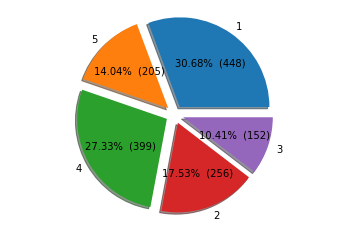

In [7]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')
plot_pie(data['Rating'])    
#dağılımı dengeli mi dengesiz mi kontrolü

In [8]:
data['Rating']=data['Rating'].astype(int)
Y = np.array(data['Rating'])
for i in range(len(data)):
    data['Rating'][i] = data['Rating'][i] - 1
y = to_categorical(data['Rating'],5)

In [16]:
data.drop('Rating',inplace = True ,axis = 1)
data.reset_index(drop = True, inplace = True)
X = np.array(data)

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression

def featureImportances(data,y):
    train_x,X_test,train_y,y_test = train_test_split(X,y,test_size=0.3,random_state=1)


    rfc = RandomForestClassifier(n_estimators=100, max_features=5) 
    rfc = rfc.fit(X,y)
    feature_importances = pd.DataFrame(rfc.feature_importances_,
                                  index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    
    print('RandomForestClassifier Feature Importances:',feature_importances)
    
    clf = DecisionTreeClassifier()
    clf = clf.fit(X,y)
    feature_importances = pd.DataFrame(clf.feature_importances_,
                                  index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    print('DecisionTreeClassifier Feature Importances:',feature_importances)
    
    sgb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    sgb = sgb.fit(train_x,train_y)
    feature_importances = pd.DataFrame(sgb.feature_importances_,
                                  index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    print('GradientBoostingClassifier Feature Importances:',feature_importances)
    pd.set_option('display.max_rows', None)
    


featureImportances(data,Y)
pd.set_option('display.max_rows', None)

RandomForestClassifier Feature Importances:                importance
SalePrice        0.050965
OpenPorchSF      0.041951
YearBuilt        0.036737
GrLivArea        0.034704
LotArea          0.034369
GarageYrBlt      0.034366
GarageArea       0.033875
1stFlrSF         0.033359
TotalBsmtSF      0.032883
BsmtUnfSF        0.032419
YearRemodAdd     0.030127
LotFrontage      0.030010
BsmtFinSF1       0.029101
MoSold           0.026065
Neighborhood     0.025953
WoodDeckSF       0.022566
YrSold           0.020564
MasVnrArea       0.018597
OverallQual      0.018496
2ndFlrSF         0.018381
TotRmsAbvGrd     0.018226
Exterior2nd      0.016890
BsmtFinType1     0.015865
Exterior1st      0.015213
MSSubClass       0.014120
OverallCond      0.013535
FireplaceQu      0.012181
BsmtExposure     0.011966
HeatingQC        0.011614
BedroomAbvGr     0.011474
HouseStyle       0.011008
LotConfig        0.010762
MasVnrType       0.010758
BsmtQual         0.010586
GarageFinish     0.010417
KitchenQual      0.0

In [ ]:
#for i in range(len(data)):
#    data['Rating'][i] = data['Rating'][i] - 1
#y = to_categorical(data['Rating'],5)
#data.drop('Rating',inplace = True ,axis = 1)
#data.reset_index(drop = True, inplace = True)
#X = np.array(data)

In [17]:
data.drop('Condition2',inplace = True ,axis = 1)
data.drop('Utilities',inplace = True ,axis = 1)
data.drop('Street',inplace = True ,axis = 1)


#data.drop('MSSubClass',inplace = True ,axis = 1)
##data.drop('HalfBath',inplace = True ,axis = 1)
#data.drop('KitchenAbvGr',inplace = True ,axis = 1)
#data.drop('CentralAir',inplace = True ,axis = 1)
#data.drop('BsmtFinType2',inplace = True ,axis = 1)
#data.drop('GarageQual',inplace = True ,axis = 1)
#data.drop('LowQualFinSF',inplace = True ,axis = 1)
data.reset_index(drop = True, inplace = True)
X = np.array(data)

In [11]:
def hyperParameterTuning(x_data,
                         y_data,
                         learning_rate = 0.001,
                         loss = 'binary_crossentropy',
                         epoch = 10,
                         batch_size = 10,
                         forget_ratio = 0.3
                        ):
                         
                            
    
    
    X_train , X_test , y_train , y_test = train_test_split(x_data,y_data,test_size=0.25,random_state=42)
    '''
    my_callbacks = (
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
    )'''

    
    
    model = Sequential()

    model.add(Dense(64,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(2048,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(forget_ratio))
    model.add(Dense(5,activation='softmax'))

    
    model.compile(optimizer = Adam(learning_rate = learning_rate),
              loss = loss,
              metrics = ['accuracy'])

    model.fit(X_train,
              y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(X_test,y_test),
              #callbacks= my_callbacks
              )          
    
    
    #result = 
    
    #print(result)
    #print("With \nlearning_rate = %f \nloss_function = %s\nepoch = %d\nbatch_size = %d\ntrain_test_split_ratio = %f\Best Accuracy = %f",learning_rate,loss,epoch,batch_size,train_test_split_ratio,result)
    

In [12]:
hyperParameterTuning(
    x_data= X,
    y_data= y,
    learning_rate = 0.001,
    #loss = 'categorical_crossentropy',
    epoch = 100,
    batch_size = 25,
    forget_ratio = 0.25)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1095 samples, validate on 365 samples
Epoch 1/100
1095/1095 [==============================] - 3s 2ms/step - loss: 0.6307 - accuracy: 0.7616 - val_loss: 0.5034 - val_accuracy: 0.7825
Epoch 2/100
1095/1095 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7834 - val_loss: 0.5026 - val_accuracy: 0.7918
Epoch 3/100
1095/1095 [==============================] - 2s 1ms/step - loss: 0.5218 - accuracy: 0.7825 - val_loss: 0.4900 - val_accuracy: 0.7995
Epoch 4/100
1095/1095 [==============================] - 2s 1ms/step - loss: 0.5274 - accuracy: 0.7817 - val_loss: 0.4755 - val_accuracy: 0.7989
Epoch 5/100
1095/1095 [==============================] - 2s 1ms/step - loss: 0.5204 - accuracy: 0.7861 - val_loss: 0.4723 - val_accuracy: 0.8000
Epoch 6/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.5127 - accuracy: 0.7843 - val

Epoch 53/100
1095/1095 [==============================] - 2s 1ms/step - loss: 0.4301 - accuracy: 0.8095 - val_loss: 0.7776 - val_accuracy: 0.6800
Epoch 54/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.4288 - accuracy: 0.8100 - val_loss: 0.4956 - val_accuracy: 0.7830
Epoch 55/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.4355 - accuracy: 0.8066 - val_loss: 0.5972 - val_accuracy: 0.7616
Epoch 56/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.4292 - accuracy: 0.8073 - val_loss: 0.6537 - val_accuracy: 0.7633
Epoch 57/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.4306 - accuracy: 0.8102 - val_loss: 0.4648 - val_accuracy: 0.8088
Epoch 58/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.4212 - accuracy: 0.8128 - val_loss: 0.4817 - val_accuracy: 0.8005
Epoch 59/100
1095/1095 [==============================] - 2s 2ms/step - loss: 0.4280 - accuracy: 0.8084 - val_loss: 0.5535 -

In [13]:
hyperParameterTuning(
    x_data= X,
    y_data= y,
    learning_rate = 0.001,
    #loss = 'categorical_crossentropy',
    epoch = 200,
    batch_size = 100,
    forget_ratio = 0.25)

Train on 1095 samples, validate on 365 samples
Epoch 1/200
1095/1095 [==============================] - 2s 2ms/step - loss: 0.7117 - accuracy: 0.7441 - val_loss: 2.4440 - val_accuracy: 0.6581
Epoch 2/200
1095/1095 [==============================] - 1s 591us/step - loss: 0.5546 - accuracy: 0.7806 - val_loss: 1.0132 - val_accuracy: 0.7068
Epoch 3/200
1095/1095 [==============================] - 1s 601us/step - loss: 0.5307 - accuracy: 0.7841 - val_loss: 0.6641 - val_accuracy: 0.7825
Epoch 4/200
1095/1095 [==============================] - 1s 706us/step - loss: 0.5216 - accuracy: 0.7881 - val_loss: 0.4984 - val_accuracy: 0.7984
Epoch 5/200
1095/1095 [==============================] - 1s 601us/step - loss: 0.5161 - accuracy: 0.7865 - val_loss: 0.5212 - val_accuracy: 0.7819
Epoch 6/200
1095/1095 [==============================] - 1s 589us/step - loss: 0.5069 - accuracy: 0.7914 - val_loss: 0.4845 - val_accuracy: 0.7967
Epoch 7/200
1095/1095 [==============================] - 1s 631us/step - 

1095/1095 [==============================] - 1s 586us/step - loss: 0.1845 - accuracy: 0.9269 - val_loss: 1.2063 - val_accuracy: 0.7540
Epoch 112/200
1095/1095 [==============================] - 1s 564us/step - loss: 0.1892 - accuracy: 0.9216 - val_loss: 0.8268 - val_accuracy: 0.7403
Epoch 113/200
1095/1095 [==============================] - 1s 561us/step - loss: 0.2090 - accuracy: 0.9127 - val_loss: 0.8781 - val_accuracy: 0.7600
Epoch 114/200
1095/1095 [==============================] - 1s 565us/step - loss: 0.1858 - accuracy: 0.9226 - val_loss: 0.8439 - val_accuracy: 0.7348
Epoch 115/200
1095/1095 [==============================] - 1s 594us/step - loss: 0.1908 - accuracy: 0.9200 - val_loss: 0.8818 - val_accuracy: 0.7556
Epoch 116/200
1095/1095 [==============================] - 1s 592us/step - loss: 0.1823 - accuracy: 0.9242 - val_loss: 0.8511 - val_accuracy: 0.7523
Epoch 117/200
1095/1095 [==============================] - 1s 616us/step - loss: 0.1893 - accuracy: 0.9224 - val_loss: 1

1095/1095 [==============================] - 1s 586us/step - loss: 0.0823 - accuracy: 0.9675 - val_loss: 1.1127 - val_accuracy: 0.7540
Epoch 167/200
1095/1095 [==============================] - 1s 577us/step - loss: 0.0916 - accuracy: 0.9666 - val_loss: 1.1829 - val_accuracy: 0.7397
Epoch 168/200
1095/1095 [==============================] - 1s 576us/step - loss: 0.0848 - accuracy: 0.9658 - val_loss: 1.4388 - val_accuracy: 0.7145
Epoch 169/200
1095/1095 [==============================] - 1s 576us/step - loss: 0.0679 - accuracy: 0.9763 - val_loss: 0.9846 - val_accuracy: 0.7490
Epoch 170/200
1095/1095 [==============================] - 1s 570us/step - loss: 0.0792 - accuracy: 0.9713 - val_loss: 0.9451 - val_accuracy: 0.7425
Epoch 171/200
1095/1095 [==============================] - 1s 569us/step - loss: 0.0730 - accuracy: 0.9711 - val_loss: 1.1233 - val_accuracy: 0.7255
Epoch 172/200
1095/1095 [==============================] - 1s 619us/step - loss: 0.0835 - accuracy: 0.9695 - val_loss: 1

In [14]:
hyperParameterTuning(
    x_data= X,
    y_data= y,
    learning_rate = 0.0001,
    #loss = 'categorical_crossentropy',
    epoch = 500,
    batch_size = 500,
    forget_ratio = 0.25)

Train on 1095 samples, validate on 365 samples
Epoch 1/500
1095/1095 [==============================] - 3s 3ms/step - loss: 0.6330 - accuracy: 0.7527 - val_loss: 0.5594 - val_accuracy: 0.7825
Epoch 2/500
1095/1095 [==============================] - 1s 526us/step - loss: 0.5701 - accuracy: 0.7742 - val_loss: 0.5392 - val_accuracy: 0.7797
Epoch 3/500
1095/1095 [==============================] - 1s 642us/step - loss: 0.5552 - accuracy: 0.7764 - val_loss: 0.5348 - val_accuracy: 0.7792
Epoch 4/500
1095/1095 [==============================] - 1s 556us/step - loss: 0.5414 - accuracy: 0.7836 - val_loss: 0.4976 - val_accuracy: 0.7984
Epoch 5/500
1095/1095 [==============================] - 1s 488us/step - loss: 0.5188 - accuracy: 0.7901 - val_loss: 0.5023 - val_accuracy: 0.8000
Epoch 6/500
1095/1095 [==============================] - 1s 475us/step - loss: 0.5248 - accuracy: 0.7861 - val_loss: 0.5074 - val_accuracy: 0.7989
Epoch 7/500
1095/1095 [==============================] - 1s 599us/step - 

1095/1095 [==============================] - 0s 398us/step - loss: 0.4376 - accuracy: 0.8153 - val_loss: 0.4655 - val_accuracy: 0.8038
Epoch 112/500
1095/1095 [==============================] - 0s 406us/step - loss: 0.4269 - accuracy: 0.8142 - val_loss: 0.4659 - val_accuracy: 0.8027
Epoch 113/500
1095/1095 [==============================] - 0s 405us/step - loss: 0.4252 - accuracy: 0.8170 - val_loss: 0.4673 - val_accuracy: 0.8033
Epoch 114/500
1095/1095 [==============================] - 0s 389us/step - loss: 0.4286 - accuracy: 0.8163 - val_loss: 0.4655 - val_accuracy: 0.8005
Epoch 115/500
1095/1095 [==============================] - 0s 386us/step - loss: 0.4405 - accuracy: 0.8128 - val_loss: 0.4649 - val_accuracy: 0.8027
Epoch 116/500
1095/1095 [==============================] - 0s 382us/step - loss: 0.4332 - accuracy: 0.8128 - val_loss: 0.4664 - val_accuracy: 0.8022
Epoch 117/500
1095/1095 [==============================] - 0s 381us/step - loss: 0.4318 - accuracy: 0.8163 - val_loss: 0

1095/1095 [==============================] - 0s 395us/step - loss: 0.3808 - accuracy: 0.8342 - val_loss: 0.6222 - val_accuracy: 0.7666
Epoch 167/500
1095/1095 [==============================] - 0s 386us/step - loss: 0.3930 - accuracy: 0.8329 - val_loss: 0.6265 - val_accuracy: 0.7573
Epoch 168/500
1095/1095 [==============================] - 0s 383us/step - loss: 0.3906 - accuracy: 0.8327 - val_loss: 0.6174 - val_accuracy: 0.7584
Epoch 169/500
1095/1095 [==============================] - 0s 383us/step - loss: 0.3999 - accuracy: 0.8303 - val_loss: 0.6152 - val_accuracy: 0.7638
Epoch 170/500
1095/1095 [==============================] - 0s 389us/step - loss: 0.3814 - accuracy: 0.8300 - val_loss: 0.6161 - val_accuracy: 0.7578
Epoch 171/500
1095/1095 [==============================] - 0s 387us/step - loss: 0.3786 - accuracy: 0.8338 - val_loss: 0.6347 - val_accuracy: 0.7567
Epoch 172/500
1095/1095 [==============================] - 0s 372us/step - loss: 0.3897 - accuracy: 0.8316 - val_loss: 0

1095/1095 [==============================] - 0s 430us/step - loss: 0.3605 - accuracy: 0.8420 - val_loss: 0.9971 - val_accuracy: 0.7342
Epoch 222/500
1095/1095 [==============================] - 0s 380us/step - loss: 0.3482 - accuracy: 0.8541 - val_loss: 1.0163 - val_accuracy: 0.7315
Epoch 223/500
1095/1095 [==============================] - 0s 431us/step - loss: 0.3470 - accuracy: 0.8513 - val_loss: 1.0345 - val_accuracy: 0.7162
Epoch 224/500
1095/1095 [==============================] - 1s 478us/step - loss: 0.3564 - accuracy: 0.8468 - val_loss: 1.0375 - val_accuracy: 0.7118
Epoch 225/500
1095/1095 [==============================] - 1s 495us/step - loss: 0.3503 - accuracy: 0.8482 - val_loss: 1.0249 - val_accuracy: 0.7134
Epoch 226/500
1095/1095 [==============================] - 1s 469us/step - loss: 0.3510 - accuracy: 0.8477 - val_loss: 0.9960 - val_accuracy: 0.7173
Epoch 227/500
1095/1095 [==============================] - 0s 400us/step - loss: 0.3602 - accuracy: 0.8440 - val_loss: 1

1095/1095 [==============================] - 0s 404us/step - loss: 0.3359 - accuracy: 0.8592 - val_loss: 1.4396 - val_accuracy: 0.7085
Epoch 277/500
1095/1095 [==============================] - 0s 379us/step - loss: 0.3237 - accuracy: 0.8592 - val_loss: 1.4195 - val_accuracy: 0.7140
Epoch 278/500
1095/1095 [==============================] - 0s 412us/step - loss: 0.3194 - accuracy: 0.8597 - val_loss: 1.3976 - val_accuracy: 0.7211
Epoch 279/500
1095/1095 [==============================] - 0s 414us/step - loss: 0.3231 - accuracy: 0.8588 - val_loss: 1.3958 - val_accuracy: 0.7205
Epoch 280/500
1095/1095 [==============================] - 0s 429us/step - loss: 0.3377 - accuracy: 0.8506 - val_loss: 1.3938 - val_accuracy: 0.7233
Epoch 281/500
1095/1095 [==============================] - 0s 428us/step - loss: 0.3529 - accuracy: 0.8468 - val_loss: 1.3865 - val_accuracy: 0.7200
Epoch 282/500
1095/1095 [==============================] - 1s 663us/step - loss: 0.3226 - accuracy: 0.8612 - val_loss: 1

1095/1095 [==============================] - 0s 384us/step - loss: 0.2972 - accuracy: 0.8732 - val_loss: 0.9560 - val_accuracy: 0.7310
Epoch 332/500
1095/1095 [==============================] - 0s 395us/step - loss: 0.2977 - accuracy: 0.8738 - val_loss: 0.9273 - val_accuracy: 0.7167
Epoch 333/500
1095/1095 [==============================] - 0s 401us/step - loss: 0.2764 - accuracy: 0.8816 - val_loss: 0.9010 - val_accuracy: 0.7195
Epoch 334/500
1095/1095 [==============================] - 0s 419us/step - loss: 0.2904 - accuracy: 0.8804 - val_loss: 0.9436 - val_accuracy: 0.7249
Epoch 335/500
1095/1095 [==============================] - 0s 429us/step - loss: 0.2943 - accuracy: 0.8711 - val_loss: 0.9999 - val_accuracy: 0.7200
Epoch 336/500
1095/1095 [==============================] - 1s 471us/step - loss: 0.3037 - accuracy: 0.8754 - val_loss: 1.0634 - val_accuracy: 0.7178
Epoch 337/500
1095/1095 [==============================] - 1s 468us/step - loss: 0.2743 - accuracy: 0.8847 - val_loss: 1

1095/1095 [==============================] - 0s 397us/step - loss: 0.2597 - accuracy: 0.8959 - val_loss: 0.5981 - val_accuracy: 0.7627
Epoch 387/500
1095/1095 [==============================] - 0s 393us/step - loss: 0.2602 - accuracy: 0.8935 - val_loss: 0.6270 - val_accuracy: 0.7671
Epoch 388/500
1095/1095 [==============================] - 0s 395us/step - loss: 0.2735 - accuracy: 0.8869 - val_loss: 0.6289 - val_accuracy: 0.7644
Epoch 389/500
1095/1095 [==============================] - 0s 396us/step - loss: 0.2519 - accuracy: 0.8950 - val_loss: 0.6298 - val_accuracy: 0.7682
Epoch 390/500
1095/1095 [==============================] - 0s 392us/step - loss: 0.2565 - accuracy: 0.8974 - val_loss: 0.6471 - val_accuracy: 0.7660
Epoch 391/500
1095/1095 [==============================] - 0s 389us/step - loss: 0.2545 - accuracy: 0.8961 - val_loss: 0.6274 - val_accuracy: 0.7704
Epoch 392/500
1095/1095 [==============================] - 0s 405us/step - loss: 0.2612 - accuracy: 0.8913 - val_loss: 0

1095/1095 [==============================] - 0s 425us/step - loss: 0.2305 - accuracy: 0.9059 - val_loss: 0.6927 - val_accuracy: 0.7578
Epoch 442/500
1095/1095 [==============================] - 1s 463us/step - loss: 0.2236 - accuracy: 0.9079 - val_loss: 0.7158 - val_accuracy: 0.7567
Epoch 443/500
1095/1095 [==============================] - 0s 450us/step - loss: 0.2388 - accuracy: 0.9019 - val_loss: 0.7364 - val_accuracy: 0.7595
Epoch 444/500
1095/1095 [==============================] - 0s 444us/step - loss: 0.2263 - accuracy: 0.9085 - val_loss: 0.7126 - val_accuracy: 0.7600
Epoch 445/500
1095/1095 [==============================] - 0s 417us/step - loss: 0.2302 - accuracy: 0.9065 - val_loss: 0.6952 - val_accuracy: 0.7589
Epoch 446/500
1095/1095 [==============================] - 0s 392us/step - loss: 0.2352 - accuracy: 0.9036 - val_loss: 0.7481 - val_accuracy: 0.7600
Epoch 447/500
1095/1095 [==============================] - 0s 396us/step - loss: 0.2267 - accuracy: 0.9072 - val_loss: 0

1095/1095 [==============================] - 0s 395us/step - loss: 0.2095 - accuracy: 0.9129 - val_loss: 0.6598 - val_accuracy: 0.7605
Epoch 497/500
1095/1095 [==============================] - 0s 396us/step - loss: 0.1902 - accuracy: 0.9251 - val_loss: 0.6611 - val_accuracy: 0.7622
Epoch 498/500
1095/1095 [==============================] - 0s 377us/step - loss: 0.1837 - accuracy: 0.9302 - val_loss: 0.6850 - val_accuracy: 0.7595
Epoch 499/500
1095/1095 [==============================] - 0s 380us/step - loss: 0.2004 - accuracy: 0.9213 - val_loss: 0.6892 - val_accuracy: 0.7605
Epoch 500/500
1095/1095 [==============================] - 0s 380us/step - loss: 0.1987 - accuracy: 0.9180 - val_loss: 0.6576 - val_accuracy: 0.7622


In [15]:
hyperParameterTuning(
    x_data= X,
    y_data= y,
    learning_rate = 0.0001,
    loss = 'categorical_crossentropy',
    epoch = 500,
    batch_size = 500,
    forget_ratio = 0.25)
#bu veri kümesi için categorical_crossentropy uygun değil.

Train on 1095 samples, validate on 365 samples
Epoch 1/500
1095/1095 [==============================] - 2s 2ms/step - loss: 2.1479 - accuracy: 0.1954 - val_loss: 2.1924 - val_accuracy: 0.0932
Epoch 2/500
1095/1095 [==============================] - 0s 441us/step - loss: 1.8274 - accuracy: 0.3005 - val_loss: 1.9694 - val_accuracy: 0.0932
Epoch 3/500
1095/1095 [==============================] - 0s 431us/step - loss: 1.7509 - accuracy: 0.2868 - val_loss: 1.8763 - val_accuracy: 0.0932
Epoch 4/500
1095/1095 [==============================] - 0s 386us/step - loss: 1.7168 - accuracy: 0.3068 - val_loss: 1.7662 - val_accuracy: 0.1671
Epoch 5/500
1095/1095 [==============================] - 0s 393us/step - loss: 1.6438 - accuracy: 0.3434 - val_loss: 1.7325 - val_accuracy: 0.1644
Epoch 6/500
1095/1095 [==============================] - 0s 386us/step - loss: 1.6447 - accuracy: 0.3489 - val_loss: 1.7147 - val_accuracy: 0.1781
Epoch 7/500
1095/1095 [==============================] - 0s 382us/step - 

1095/1095 [==============================] - 0s 408us/step - loss: 1.2161 - accuracy: 0.5187 - val_loss: 1.4989 - val_accuracy: 0.3014
Epoch 112/500
1095/1095 [==============================] - 0s 391us/step - loss: 1.2280 - accuracy: 0.5041 - val_loss: 1.5140 - val_accuracy: 0.3096
Epoch 113/500
1095/1095 [==============================] - 0s 393us/step - loss: 1.1489 - accuracy: 0.5534 - val_loss: 1.5182 - val_accuracy: 0.3178
Epoch 114/500
1095/1095 [==============================] - 0s 400us/step - loss: 1.1238 - accuracy: 0.5653 - val_loss: 1.5155 - val_accuracy: 0.3068
Epoch 115/500
1095/1095 [==============================] - 0s 392us/step - loss: 1.1475 - accuracy: 0.5553 - val_loss: 1.5117 - val_accuracy: 0.3096
Epoch 116/500
1095/1095 [==============================] - 0s 395us/step - loss: 1.1402 - accuracy: 0.5525 - val_loss: 1.5172 - val_accuracy: 0.3096
Epoch 117/500
1095/1095 [==============================] - 0s 381us/step - loss: 1.1859 - accuracy: 0.5352 - val_loss: 1

1095/1095 [==============================] - 1s 493us/step - loss: 1.0283 - accuracy: 0.5881 - val_loss: 1.6656 - val_accuracy: 0.3123
Epoch 167/500
1095/1095 [==============================] - 1s 549us/step - loss: 1.0696 - accuracy: 0.5680 - val_loss: 1.6682 - val_accuracy: 0.3096
Epoch 168/500
1095/1095 [==============================] - 1s 497us/step - loss: 1.0514 - accuracy: 0.5936 - val_loss: 1.6079 - val_accuracy: 0.3370
Epoch 169/500
1095/1095 [==============================] - 1s 489us/step - loss: 1.0258 - accuracy: 0.6055 - val_loss: 1.6752 - val_accuracy: 0.3178
Epoch 170/500
1095/1095 [==============================] - 1s 547us/step - loss: 0.9957 - accuracy: 0.6064 - val_loss: 1.7451 - val_accuracy: 0.3014
Epoch 171/500
1095/1095 [==============================] - 1s 462us/step - loss: 1.0394 - accuracy: 0.5863 - val_loss: 1.6073 - val_accuracy: 0.3507
Epoch 172/500
1095/1095 [==============================] - 0s 424us/step - loss: 1.0260 - accuracy: 0.5945 - val_loss: 1

1095/1095 [==============================] - 0s 404us/step - loss: 0.9290 - accuracy: 0.6457 - val_loss: 1.7354 - val_accuracy: 0.3699
Epoch 222/500
1095/1095 [==============================] - 0s 399us/step - loss: 0.8904 - accuracy: 0.6539 - val_loss: 1.7543 - val_accuracy: 0.3753
Epoch 223/500
1095/1095 [==============================] - 1s 523us/step - loss: 0.8846 - accuracy: 0.6712 - val_loss: 1.7702 - val_accuracy: 0.3425
Epoch 224/500
1095/1095 [==============================] - 1s 614us/step - loss: 0.9169 - accuracy: 0.6484 - val_loss: 1.7417 - val_accuracy: 0.3452
Epoch 225/500
1095/1095 [==============================] - 1s 636us/step - loss: 0.8656 - accuracy: 0.6639 - val_loss: 1.7077 - val_accuracy: 0.3479
Epoch 226/500
1095/1095 [==============================] - 1s 555us/step - loss: 0.8587 - accuracy: 0.6530 - val_loss: 1.7030 - val_accuracy: 0.3315
Epoch 227/500
1095/1095 [==============================] - 1s 518us/step - loss: 0.8905 - accuracy: 0.6776 - val_loss: 1

1095/1095 [==============================] - 0s 398us/step - loss: 0.7974 - accuracy: 0.6785 - val_loss: 1.8846 - val_accuracy: 0.3288
Epoch 277/500
1095/1095 [==============================] - 0s 399us/step - loss: 0.7857 - accuracy: 0.7023 - val_loss: 1.8590 - val_accuracy: 0.3616
Epoch 278/500
1095/1095 [==============================] - 0s 395us/step - loss: 0.8226 - accuracy: 0.6758 - val_loss: 1.8611 - val_accuracy: 0.3260
Epoch 279/500
1095/1095 [==============================] - 0s 387us/step - loss: 0.7852 - accuracy: 0.6895 - val_loss: 1.8965 - val_accuracy: 0.3315
Epoch 280/500
1095/1095 [==============================] - 0s 393us/step - loss: 0.7539 - accuracy: 0.7169 - val_loss: 1.8958 - val_accuracy: 0.3315
Epoch 281/500
1095/1095 [==============================] - 0s 399us/step - loss: 0.7893 - accuracy: 0.6904 - val_loss: 1.9181 - val_accuracy: 0.3342
Epoch 282/500
1095/1095 [==============================] - 0s 414us/step - loss: 0.7438 - accuracy: 0.7169 - val_loss: 1

1095/1095 [==============================] - 0s 401us/step - loss: 0.7011 - accuracy: 0.7425 - val_loss: 1.9796 - val_accuracy: 0.3151
Epoch 332/500
1095/1095 [==============================] - 0s 395us/step - loss: 0.6699 - accuracy: 0.7470 - val_loss: 1.9710 - val_accuracy: 0.3452
Epoch 333/500
1095/1095 [==============================] - 0s 395us/step - loss: 0.6590 - accuracy: 0.7543 - val_loss: 2.0086 - val_accuracy: 0.3452
Epoch 334/500
1095/1095 [==============================] - 0s 401us/step - loss: 0.6735 - accuracy: 0.7388 - val_loss: 1.9609 - val_accuracy: 0.3534
Epoch 335/500
1095/1095 [==============================] - 0s 388us/step - loss: 0.7057 - accuracy: 0.7251 - val_loss: 1.9558 - val_accuracy: 0.3452
Epoch 336/500
1095/1095 [==============================] - 0s 394us/step - loss: 0.7192 - accuracy: 0.7324 - val_loss: 2.0206 - val_accuracy: 0.3534
Epoch 337/500
1095/1095 [==============================] - 0s 408us/step - loss: 0.7012 - accuracy: 0.7178 - val_loss: 1

1095/1095 [==============================] - 0s 394us/step - loss: 0.6000 - accuracy: 0.7717 - val_loss: 2.0787 - val_accuracy: 0.3315
Epoch 387/500
1095/1095 [==============================] - 0s 397us/step - loss: 0.6497 - accuracy: 0.7470 - val_loss: 2.0790 - val_accuracy: 0.3452
Epoch 388/500
1095/1095 [==============================] - 0s 402us/step - loss: 0.6459 - accuracy: 0.7626 - val_loss: 1.9807 - val_accuracy: 0.3589
Epoch 389/500
1095/1095 [==============================] - 0s 394us/step - loss: 0.6106 - accuracy: 0.7744 - val_loss: 2.0106 - val_accuracy: 0.3479
Epoch 390/500
1095/1095 [==============================] - 0s 410us/step - loss: 0.5662 - accuracy: 0.7973 - val_loss: 2.0788 - val_accuracy: 0.3479
Epoch 391/500
1095/1095 [==============================] - 0s 386us/step - loss: 0.5939 - accuracy: 0.7689 - val_loss: 2.0731 - val_accuracy: 0.3178
Epoch 392/500
1095/1095 [==============================] - 0s 413us/step - loss: 0.6021 - accuracy: 0.7845 - val_loss: 2

1095/1095 [==============================] - 1s 472us/step - loss: 0.5880 - accuracy: 0.7826 - val_loss: 2.3962 - val_accuracy: 0.3753
Epoch 442/500
1095/1095 [==============================] - 0s 421us/step - loss: 0.6172 - accuracy: 0.7653 - val_loss: 2.3274 - val_accuracy: 0.3397
Epoch 443/500
1095/1095 [==============================] - 1s 465us/step - loss: 0.5188 - accuracy: 0.8110 - val_loss: 2.3868 - val_accuracy: 0.3534
Epoch 444/500
1095/1095 [==============================] - 0s 450us/step - loss: 0.5513 - accuracy: 0.7872 - val_loss: 2.2413 - val_accuracy: 0.3425
Epoch 445/500
1095/1095 [==============================] - 1s 524us/step - loss: 0.5233 - accuracy: 0.8164 - val_loss: 2.1482 - val_accuracy: 0.3726
Epoch 446/500
1095/1095 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.81 - 1s 689us/step - loss: 0.5268 - accuracy: 0.8082 - val_loss: 2.0935 - val_accuracy: 0.3890
Epoch 447/500
1095/1095 [==============================] - 1s 690us/step - los

Epoch 496/500
1095/1095 [==============================] - 0s 405us/step - loss: 0.4474 - accuracy: 0.8466 - val_loss: 2.1884 - val_accuracy: 0.3534
Epoch 497/500
1095/1095 [==============================] - 0s 406us/step - loss: 0.5115 - accuracy: 0.8137 - val_loss: 2.2586 - val_accuracy: 0.3397
Epoch 498/500
1095/1095 [==============================] - 0s 403us/step - loss: 0.4951 - accuracy: 0.8274 - val_loss: 2.2305 - val_accuracy: 0.3616
Epoch 499/500
1095/1095 [==============================] - 0s 403us/step - loss: 0.4686 - accuracy: 0.8210 - val_loss: 2.2287 - val_accuracy: 0.3452
Epoch 500/500
1095/1095 [==============================] - 0s 400us/step - loss: 0.5327 - accuracy: 0.8055 - val_loss: 2.2023 - val_accuracy: 0.3534


In [16]:
hyperParameterTuning(
    x_data= X,
    y_data= y,
    learning_rate = 0.0001,
    #loss = 'categorical_crossentropy',
    epoch = 5000,
    batch_size = 5000,
    forget_ratio = 0.25)

Train on 1095 samples, validate on 365 samples
Epoch 1/5000
1095/1095 [==============================] - 3s 3ms/step - loss: 0.6585 - accuracy: 0.7503 - val_loss: 1.3633 - val_accuracy: 0.6389
Epoch 2/5000
1095/1095 [==============================] - 1s 542us/step - loss: 0.6219 - accuracy: 0.7679 - val_loss: 0.9985 - val_accuracy: 0.6433
Epoch 3/5000
1095/1095 [==============================] - 0s 433us/step - loss: 0.5695 - accuracy: 0.7763 - val_loss: 0.7203 - val_accuracy: 0.7605
Epoch 4/5000
1095/1095 [==============================] - 0s 343us/step - loss: 0.5641 - accuracy: 0.7795 - val_loss: 0.6475 - val_accuracy: 0.7890
Epoch 5/5000
1095/1095 [==============================] - 0s 437us/step - loss: 0.5388 - accuracy: 0.7803 - val_loss: 0.6127 - val_accuracy: 0.7923
Epoch 6/5000
1095/1095 [==============================] - 0s 420us/step - loss: 0.5264 - accuracy: 0.7901 - val_loss: 0.6011 - val_accuracy: 0.7989
Epoch 7/5000
1095/1095 [==============================] - 0s 395us/

Epoch 56/5000
1095/1095 [==============================] - 0s 325us/step - loss: 0.4076 - accuracy: 0.8234 - val_loss: 0.5115 - val_accuracy: 0.7995
Epoch 57/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.4073 - accuracy: 0.8256 - val_loss: 0.5108 - val_accuracy: 0.7995
Epoch 58/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.3997 - accuracy: 0.8287 - val_loss: 0.5105 - val_accuracy: 0.7984
Epoch 59/5000
1095/1095 [==============================] - 0s 338us/step - loss: 0.3964 - accuracy: 0.8258 - val_loss: 0.5113 - val_accuracy: 0.7978
Epoch 60/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.4001 - accuracy: 0.8217 - val_loss: 0.5122 - val_accuracy: 0.7962
Epoch 61/5000
1095/1095 [==============================] - 0s 347us/step - loss: 0.3920 - accuracy: 0.8312 - val_loss: 0.5121 - val_accuracy: 0.7962
Epoch 62/5000
1095/1095 [==============================] - 0s 369us/step - loss: 0.3922 - accuracy: 0.8323

Epoch 111/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.3127 - accuracy: 0.8687 - val_loss: 0.4979 - val_accuracy: 0.7956
Epoch 112/5000
1095/1095 [==============================] - 0s 344us/step - loss: 0.3051 - accuracy: 0.8681 - val_loss: 0.4972 - val_accuracy: 0.7962
Epoch 113/5000
1095/1095 [==============================] - 0s 345us/step - loss: 0.3170 - accuracy: 0.8648 - val_loss: 0.4984 - val_accuracy: 0.7951
Epoch 114/5000
1095/1095 [==============================] - 0s 342us/step - loss: 0.3148 - accuracy: 0.8659 - val_loss: 0.4975 - val_accuracy: 0.7956
Epoch 115/5000
1095/1095 [==============================] - 0s 412us/step - loss: 0.2978 - accuracy: 0.8776 - val_loss: 0.4953 - val_accuracy: 0.7978
Epoch 116/5000
1095/1095 [==============================] - 1s 519us/step - loss: 0.3102 - accuracy: 0.8674 - val_loss: 0.4949 - val_accuracy: 0.7978
Epoch 117/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.3109 - accuracy:

Epoch 166/5000
1095/1095 [==============================] - 1s 799us/step - loss: 0.2426 - accuracy: 0.9019 - val_loss: 0.4899 - val_accuracy: 0.7967
Epoch 167/5000
1095/1095 [==============================] - 1s 551us/step - loss: 0.2373 - accuracy: 0.9039 - val_loss: 0.4876 - val_accuracy: 0.7978
Epoch 168/5000
1095/1095 [==============================] - 1s 612us/step - loss: 0.2422 - accuracy: 0.9014 - val_loss: 0.4887 - val_accuracy: 0.7973
Epoch 169/5000
1095/1095 [==============================] - 1s 468us/step - loss: 0.2357 - accuracy: 0.9034 - val_loss: 0.4897 - val_accuracy: 0.7978
Epoch 170/5000
1095/1095 [==============================] - 1s 552us/step - loss: 0.2396 - accuracy: 0.9045 - val_loss: 0.4876 - val_accuracy: 0.7984
Epoch 171/5000
1095/1095 [==============================] - 1s 528us/step - loss: 0.2451 - accuracy: 0.8981 - val_loss: 0.4885 - val_accuracy: 0.7978
Epoch 172/5000
1095/1095 [==============================] - 1s 571us/step - loss: 0.2302 - accuracy:

Epoch 221/5000
1095/1095 [==============================] - 0s 340us/step - loss: 0.1874 - accuracy: 0.9308 - val_loss: 0.4879 - val_accuracy: 0.7956
Epoch 222/5000
1095/1095 [==============================] - 0s 332us/step - loss: 0.1812 - accuracy: 0.9357 - val_loss: 0.4884 - val_accuracy: 0.7945
Epoch 223/5000
1095/1095 [==============================] - 0s 330us/step - loss: 0.1824 - accuracy: 0.9319 - val_loss: 0.4882 - val_accuracy: 0.7956
Epoch 224/5000
1095/1095 [==============================] - 0s 328us/step - loss: 0.1783 - accuracy: 0.9372 - val_loss: 0.4852 - val_accuracy: 0.7973
Epoch 225/5000
1095/1095 [==============================] - 0s 326us/step - loss: 0.1816 - accuracy: 0.9297 - val_loss: 0.4875 - val_accuracy: 0.7978
Epoch 226/5000
1095/1095 [==============================] - 0s 331us/step - loss: 0.1728 - accuracy: 0.9390 - val_loss: 0.4868 - val_accuracy: 0.7978
Epoch 227/5000
1095/1095 [==============================] - 0s 332us/step - loss: 0.1748 - accuracy:

Epoch 276/5000
1095/1095 [==============================] - 0s 346us/step - loss: 0.1410 - accuracy: 0.9536 - val_loss: 0.4882 - val_accuracy: 0.7923
Epoch 277/5000
1095/1095 [==============================] - 0s 334us/step - loss: 0.1486 - accuracy: 0.9479 - val_loss: 0.4924 - val_accuracy: 0.7923
Epoch 278/5000
1095/1095 [==============================] - 0s 329us/step - loss: 0.1414 - accuracy: 0.9523 - val_loss: 0.4917 - val_accuracy: 0.7918
Epoch 279/5000
1095/1095 [==============================] - 0s 336us/step - loss: 0.1478 - accuracy: 0.9501 - val_loss: 0.4893 - val_accuracy: 0.7918
Epoch 280/5000
1095/1095 [==============================] - 0s 334us/step - loss: 0.1367 - accuracy: 0.9540 - val_loss: 0.4970 - val_accuracy: 0.7874
Epoch 281/5000
1095/1095 [==============================] - 0s 329us/step - loss: 0.1355 - accuracy: 0.9560 - val_loss: 0.4947 - val_accuracy: 0.7879
Epoch 282/5000
1095/1095 [==============================] - 0s 315us/step - loss: 0.1338 - accuracy:

Epoch 331/5000
1095/1095 [==============================] - 1s 589us/step - loss: 0.1122 - accuracy: 0.9658 - val_loss: 0.5199 - val_accuracy: 0.7666
Epoch 332/5000
1095/1095 [==============================] - 1s 471us/step - loss: 0.1175 - accuracy: 0.9589 - val_loss: 0.5127 - val_accuracy: 0.7649
Epoch 333/5000
1095/1095 [==============================] - 1s 843us/step - loss: 0.1218 - accuracy: 0.9585 - val_loss: 0.5230 - val_accuracy: 0.7600
Epoch 334/5000
1095/1095 [==============================] - 1s 972us/step - loss: 0.1079 - accuracy: 0.9699 - val_loss: 0.5174 - val_accuracy: 0.7666
Epoch 335/5000
1095/1095 [==============================] - 1s 720us/step - loss: 0.1133 - accuracy: 0.9631 - val_loss: 0.5136 - val_accuracy: 0.7660
Epoch 336/5000
1095/1095 [==============================] - 1s 503us/step - loss: 0.1222 - accuracy: 0.9587 - val_loss: 0.5397 - val_accuracy: 0.7545
Epoch 337/5000
1095/1095 [==============================] - 1s 739us/step - loss: 0.1301 - accuracy:

Epoch 386/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0871 - accuracy: 0.9748 - val_loss: 0.5838 - val_accuracy: 0.7441
Epoch 387/5000
1095/1095 [==============================] - 0s 332us/step - loss: 0.0874 - accuracy: 0.9775 - val_loss: 0.5521 - val_accuracy: 0.7573
Epoch 388/5000
1095/1095 [==============================] - 0s 336us/step - loss: 0.0855 - accuracy: 0.9794 - val_loss: 0.5605 - val_accuracy: 0.7529
Epoch 389/5000
1095/1095 [==============================] - 0s 369us/step - loss: 0.0920 - accuracy: 0.9732 - val_loss: 0.5913 - val_accuracy: 0.7436
Epoch 390/5000
1095/1095 [==============================] - 0s 423us/step - loss: 0.0931 - accuracy: 0.9726 - val_loss: 0.5541 - val_accuracy: 0.7540
Epoch 391/5000
1095/1095 [==============================] - 0s 436us/step - loss: 0.0918 - accuracy: 0.9732 - val_loss: 0.5644 - val_accuracy: 0.7534
Epoch 392/5000
1095/1095 [==============================] - 0s 411us/step - loss: 0.0828 - accuracy:

Epoch 441/5000
1095/1095 [==============================] - 0s 352us/step - loss: 0.0687 - accuracy: 0.9850 - val_loss: 0.5881 - val_accuracy: 0.7485
Epoch 442/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0699 - accuracy: 0.9832 - val_loss: 0.6065 - val_accuracy: 0.7458
Epoch 443/5000
1095/1095 [==============================] - 0s 349us/step - loss: 0.0709 - accuracy: 0.9836 - val_loss: 0.5932 - val_accuracy: 0.7463
Epoch 444/5000
1095/1095 [==============================] - 0s 411us/step - loss: 0.0696 - accuracy: 0.9814 - val_loss: 0.6409 - val_accuracy: 0.7364
Epoch 445/5000
1095/1095 [==============================] - 0s 383us/step - loss: 0.0659 - accuracy: 0.9872 - val_loss: 0.6335 - val_accuracy: 0.7397
Epoch 446/5000
1095/1095 [==============================] - 0s 384us/step - loss: 0.0627 - accuracy: 0.9876 - val_loss: 0.6127 - val_accuracy: 0.7474
Epoch 447/5000
1095/1095 [==============================] - 0s 425us/step - loss: 0.0685 - accuracy:

Epoch 496/5000
1095/1095 [==============================] - 0s 423us/step - loss: 0.0571 - accuracy: 0.9876 - val_loss: 0.6616 - val_accuracy: 0.7386
Epoch 497/5000
1095/1095 [==============================] - 0s 417us/step - loss: 0.0594 - accuracy: 0.9859 - val_loss: 0.5952 - val_accuracy: 0.7611
Epoch 498/5000
1095/1095 [==============================] - 0s 439us/step - loss: 0.0657 - accuracy: 0.9817 - val_loss: 0.6632 - val_accuracy: 0.7441
Epoch 499/5000
1095/1095 [==============================] - 0s 451us/step - loss: 0.0609 - accuracy: 0.9870 - val_loss: 0.6714 - val_accuracy: 0.7403
Epoch 500/5000
1095/1095 [==============================] - 0s 446us/step - loss: 0.0534 - accuracy: 0.9909 - val_loss: 0.6233 - val_accuracy: 0.7463
Epoch 501/5000
1095/1095 [==============================] - 1s 505us/step - loss: 0.0633 - accuracy: 0.9832 - val_loss: 0.6906 - val_accuracy: 0.7397
Epoch 502/5000
1095/1095 [==============================] - 1s 492us/step - loss: 0.0642 - accuracy:

Epoch 551/5000
1095/1095 [==============================] - 0s 401us/step - loss: 0.0491 - accuracy: 0.9903 - val_loss: 0.7251 - val_accuracy: 0.7370
Epoch 552/5000
1095/1095 [==============================] - 0s 382us/step - loss: 0.0485 - accuracy: 0.9896 - val_loss: 0.7336 - val_accuracy: 0.7392
Epoch 553/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0494 - accuracy: 0.9903 - val_loss: 0.7219 - val_accuracy: 0.7381
Epoch 554/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0463 - accuracy: 0.9921 - val_loss: 0.7262 - val_accuracy: 0.7414
Epoch 555/5000
1095/1095 [==============================] - 0s 396us/step - loss: 0.0459 - accuracy: 0.9921 - val_loss: 0.7215 - val_accuracy: 0.7425
Epoch 556/5000
1095/1095 [==============================] - 1s 500us/step - loss: 0.0488 - accuracy: 0.9898 - val_loss: 0.7542 - val_accuracy: 0.7348
Epoch 557/5000
1095/1095 [==============================] - 1s 494us/step - loss: 0.0489 - accuracy:

Epoch 606/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0451 - accuracy: 0.9883 - val_loss: 0.8225 - val_accuracy: 0.7271
Epoch 607/5000
1095/1095 [==============================] - 0s 361us/step - loss: 0.0497 - accuracy: 0.9889 - val_loss: 0.7226 - val_accuracy: 0.7419
Epoch 608/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0434 - accuracy: 0.9903 - val_loss: 0.7403 - val_accuracy: 0.7364
Epoch 609/5000
1095/1095 [==============================] - 0s 434us/step - loss: 0.0393 - accuracy: 0.9927 - val_loss: 0.7731 - val_accuracy: 0.7332
Epoch 610/5000
1095/1095 [==============================] - 1s 467us/step - loss: 0.0400 - accuracy: 0.9931 - val_loss: 0.7273 - val_accuracy: 0.7370
Epoch 611/5000
1095/1095 [==============================] - 0s 455us/step - loss: 0.0376 - accuracy: 0.9936 - val_loss: 0.7494 - val_accuracy: 0.7359
Epoch 612/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0400 - accuracy:

Epoch 661/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0355 - accuracy: 0.9920 - val_loss: 0.8032 - val_accuracy: 0.7353
Epoch 662/5000
1095/1095 [==============================] - 0s 353us/step - loss: 0.0334 - accuracy: 0.9954 - val_loss: 0.8383 - val_accuracy: 0.7310
Epoch 663/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0333 - accuracy: 0.9938 - val_loss: 0.7685 - val_accuracy: 0.7381
Epoch 664/5000
1095/1095 [==============================] - 0s 353us/step - loss: 0.0344 - accuracy: 0.9945 - val_loss: 0.7984 - val_accuracy: 0.7375
Epoch 665/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0309 - accuracy: 0.9947 - val_loss: 0.8484 - val_accuracy: 0.7282
Epoch 666/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0337 - accuracy: 0.9942 - val_loss: 0.7680 - val_accuracy: 0.7386
Epoch 667/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0321 - accuracy:

Epoch 716/5000
1095/1095 [==============================] - 0s 344us/step - loss: 0.0279 - accuracy: 0.9967 - val_loss: 0.8500 - val_accuracy: 0.7266
Epoch 717/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0298 - accuracy: 0.9949 - val_loss: 0.8771 - val_accuracy: 0.7299
Epoch 718/5000
1095/1095 [==============================] - 0s 394us/step - loss: 0.0266 - accuracy: 0.9971 - val_loss: 0.8924 - val_accuracy: 0.7310
Epoch 719/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0276 - accuracy: 0.9962 - val_loss: 0.8743 - val_accuracy: 0.7266
Epoch 720/5000
1095/1095 [==============================] - 0s 366us/step - loss: 0.0269 - accuracy: 0.9967 - val_loss: 0.8533 - val_accuracy: 0.7282
Epoch 721/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0269 - accuracy: 0.9954 - val_loss: 0.8617 - val_accuracy: 0.7310
Epoch 722/5000
1095/1095 [==============================] - 1s 509us/step - loss: 0.0249 - accuracy:

Epoch 771/5000
1095/1095 [==============================] - 1s 468us/step - loss: 0.0235 - accuracy: 0.9971 - val_loss: 0.8741 - val_accuracy: 0.7310
Epoch 772/5000
1095/1095 [==============================] - 1s 516us/step - loss: 0.0238 - accuracy: 0.9969 - val_loss: 0.9034 - val_accuracy: 0.7211
Epoch 773/5000
1095/1095 [==============================] - 1s 478us/step - loss: 0.0231 - accuracy: 0.9976 - val_loss: 0.9064 - val_accuracy: 0.7205
Epoch 774/5000
1095/1095 [==============================] - 1s 566us/step - loss: 0.0240 - accuracy: 0.9965 - val_loss: 0.8619 - val_accuracy: 0.7321
Epoch 775/5000
1095/1095 [==============================] - 1s 499us/step - loss: 0.0241 - accuracy: 0.9962 - val_loss: 0.8765 - val_accuracy: 0.7244
Epoch 776/5000
1095/1095 [==============================] - 1s 500us/step - loss: 0.0253 - accuracy: 0.9971 - val_loss: 0.9248 - val_accuracy: 0.7266
Epoch 777/5000
1095/1095 [==============================] - 1s 488us/step - loss: 0.0231 - accuracy:

Epoch 826/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0219 - accuracy: 0.9978 - val_loss: 0.9505 - val_accuracy: 0.7315
Epoch 827/5000
1095/1095 [==============================] - 1s 545us/step - loss: 0.0219 - accuracy: 0.9978 - val_loss: 0.9610 - val_accuracy: 0.7277
Epoch 828/5000
1095/1095 [==============================] - 1s 479us/step - loss: 0.0204 - accuracy: 0.9971 - val_loss: 0.9536 - val_accuracy: 0.7266
Epoch 829/5000
1095/1095 [==============================] - 1s 541us/step - loss: 0.0208 - accuracy: 0.9971 - val_loss: 0.9547 - val_accuracy: 0.7282
Epoch 830/5000
1095/1095 [==============================] - 1s 522us/step - loss: 0.0228 - accuracy: 0.9965 - val_loss: 0.9642 - val_accuracy: 0.7238
Epoch 831/5000
1095/1095 [==============================] - 1s 525us/step - loss: 0.0209 - accuracy: 0.9971 - val_loss: 0.9508 - val_accuracy: 0.7277
Epoch 832/5000
1095/1095 [==============================] - 1s 560us/step - loss: 0.0209 - accuracy:

Epoch 881/5000
1095/1095 [==============================] - 0s 359us/step - loss: 0.0181 - accuracy: 0.9980 - val_loss: 1.0045 - val_accuracy: 0.7249
Epoch 882/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0192 - accuracy: 0.9965 - val_loss: 0.9883 - val_accuracy: 0.7255
Epoch 883/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0176 - accuracy: 0.9982 - val_loss: 0.9841 - val_accuracy: 0.7293
Epoch 884/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0178 - accuracy: 0.9982 - val_loss: 0.9729 - val_accuracy: 0.7288
Epoch 885/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0166 - accuracy: 0.9984 - val_loss: 0.9723 - val_accuracy: 0.7304
Epoch 886/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0170 - accuracy: 0.9987 - val_loss: 0.9781 - val_accuracy: 0.7277
Epoch 887/5000
1095/1095 [==============================] - 0s 382us/step - loss: 0.0180 - accuracy:

Epoch 936/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0180 - accuracy: 0.9980 - val_loss: 1.0253 - val_accuracy: 0.7233
Epoch 937/5000
1095/1095 [==============================] - 0s 369us/step - loss: 0.0174 - accuracy: 0.9985 - val_loss: 1.0209 - val_accuracy: 0.7205
Epoch 938/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0168 - accuracy: 0.9976 - val_loss: 1.0132 - val_accuracy: 0.7216
Epoch 939/5000
1095/1095 [==============================] - 0s 366us/step - loss: 0.0179 - accuracy: 0.9967 - val_loss: 1.0307 - val_accuracy: 0.7162
Epoch 940/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0180 - accuracy: 0.9974 - val_loss: 1.0381 - val_accuracy: 0.7200
Epoch 941/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0176 - accuracy: 0.9974 - val_loss: 1.0436 - val_accuracy: 0.7200
Epoch 942/5000
1095/1095 [==============================] - 0s 352us/step - loss: 0.0180 - accuracy:

Epoch 991/5000
1095/1095 [==============================] - 1s 496us/step - loss: 0.1340 - accuracy: 0.9518 - val_loss: 1.3808 - val_accuracy: 0.6860
Epoch 992/5000
1095/1095 [==============================] - 1s 500us/step - loss: 0.1328 - accuracy: 0.9521 - val_loss: 1.3715 - val_accuracy: 0.6871
Epoch 993/5000
1095/1095 [==============================] - 1s 486us/step - loss: 0.1298 - accuracy: 0.9536 - val_loss: 1.3463 - val_accuracy: 0.6932
Epoch 994/5000
1095/1095 [==============================] - 1s 486us/step - loss: 0.1205 - accuracy: 0.9595 - val_loss: 1.2921 - val_accuracy: 0.6910
Epoch 995/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.1185 - accuracy: 0.9585 - val_loss: 1.2758 - val_accuracy: 0.6937
Epoch 996/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.1039 - accuracy: 0.9660 - val_loss: 1.2655 - val_accuracy: 0.6992
Epoch 997/5000
1095/1095 [==============================] - 0s 425us/step - loss: 0.1080 - accuracy:

Epoch 1046/5000
1095/1095 [==============================] - 0s 438us/step - loss: 0.0410 - accuracy: 0.9903 - val_loss: 1.0071 - val_accuracy: 0.7282
Epoch 1047/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0383 - accuracy: 0.9925 - val_loss: 1.0003 - val_accuracy: 0.7249
Epoch 1048/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0361 - accuracy: 0.9916 - val_loss: 1.0243 - val_accuracy: 0.7238
Epoch 1049/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0427 - accuracy: 0.9865 - val_loss: 1.0212 - val_accuracy: 0.7167
Epoch 1050/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0323 - accuracy: 0.9940 - val_loss: 1.0501 - val_accuracy: 0.7238
Epoch 1051/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0354 - accuracy: 0.9923 - val_loss: 1.0878 - val_accuracy: 0.7189
Epoch 1052/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0417 - ac

Epoch 1101/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0178 - accuracy: 0.9984 - val_loss: 1.0241 - val_accuracy: 0.7189
Epoch 1102/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0170 - accuracy: 0.9989 - val_loss: 1.0206 - val_accuracy: 0.7167
Epoch 1103/5000
1095/1095 [==============================] - 0s 372us/step - loss: 0.0173 - accuracy: 0.9985 - val_loss: 1.0200 - val_accuracy: 0.7145
Epoch 1104/5000
1095/1095 [==============================] - 0s 374us/step - loss: 0.0183 - accuracy: 0.9967 - val_loss: 1.0164 - val_accuracy: 0.7205
Epoch 1105/5000
1095/1095 [==============================] - 1s 473us/step - loss: 0.0165 - accuracy: 0.9991 - val_loss: 1.0259 - val_accuracy: 0.7189
Epoch 1106/5000
1095/1095 [==============================] - 0s 353us/step - loss: 0.0199 - accuracy: 0.9963 - val_loss: 1.0372 - val_accuracy: 0.7222
Epoch 1107/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0191 - ac

Epoch 1156/5000
1095/1095 [==============================] - 1s 470us/step - loss: 0.0146 - accuracy: 0.9985 - val_loss: 1.0357 - val_accuracy: 0.7266
Epoch 1157/5000
1095/1095 [==============================] - 1s 477us/step - loss: 0.0150 - accuracy: 0.9976 - val_loss: 1.0440 - val_accuracy: 0.7249
Epoch 1158/5000
1095/1095 [==============================] - 1s 498us/step - loss: 0.0135 - accuracy: 0.9985 - val_loss: 1.0482 - val_accuracy: 0.7249
Epoch 1159/5000
1095/1095 [==============================] - 0s 445us/step - loss: 0.0139 - accuracy: 0.9980 - val_loss: 1.0547 - val_accuracy: 0.7249
Epoch 1160/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0151 - accuracy: 0.9971 - val_loss: 1.0573 - val_accuracy: 0.7200
Epoch 1161/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0146 - accuracy: 0.9985 - val_loss: 1.0540 - val_accuracy: 0.7216
Epoch 1162/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0137 - ac

Epoch 1211/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0137 - accuracy: 0.9978 - val_loss: 1.0770 - val_accuracy: 0.7381
Epoch 1212/5000
1095/1095 [==============================] - 0s 361us/step - loss: 0.0145 - accuracy: 0.9969 - val_loss: 1.0661 - val_accuracy: 0.7326
Epoch 1213/5000
1095/1095 [==============================] - 0s 369us/step - loss: 0.0113 - accuracy: 0.9978 - val_loss: 1.0738 - val_accuracy: 0.7293
Epoch 1214/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0148 - accuracy: 0.9980 - val_loss: 1.0721 - val_accuracy: 0.7370
Epoch 1215/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0126 - accuracy: 0.9980 - val_loss: 1.0868 - val_accuracy: 0.7348
Epoch 1216/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0141 - accuracy: 0.9976 - val_loss: 1.1109 - val_accuracy: 0.7304
Epoch 1217/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0131 - ac

Epoch 1266/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0130 - accuracy: 0.9984 - val_loss: 1.1262 - val_accuracy: 0.7304
Epoch 1267/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0114 - accuracy: 0.9984 - val_loss: 1.1536 - val_accuracy: 0.7332
Epoch 1268/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0154 - accuracy: 0.9965 - val_loss: 1.1347 - val_accuracy: 0.7332
Epoch 1269/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0154 - accuracy: 0.9971 - val_loss: 1.1315 - val_accuracy: 0.7277
Epoch 1270/5000
1095/1095 [==============================] - 0s 361us/step - loss: 0.0141 - accuracy: 0.9974 - val_loss: 1.1572 - val_accuracy: 0.7277
Epoch 1271/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0144 - accuracy: 0.9976 - val_loss: 1.1250 - val_accuracy: 0.7321
Epoch 1272/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0102 - ac

Epoch 1321/5000
1095/1095 [==============================] - 0s 366us/step - loss: 0.0091 - accuracy: 0.9987 - val_loss: 1.1176 - val_accuracy: 0.7266
Epoch 1322/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0099 - accuracy: 0.9982 - val_loss: 1.1202 - val_accuracy: 0.7260
Epoch 1323/5000
1095/1095 [==============================] - 0s 372us/step - loss: 0.0101 - accuracy: 0.9984 - val_loss: 1.1297 - val_accuracy: 0.7195
Epoch 1324/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0080 - accuracy: 0.9996 - val_loss: 1.1433 - val_accuracy: 0.7249
Epoch 1325/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0092 - accuracy: 0.9996 - val_loss: 1.1372 - val_accuracy: 0.7255
Epoch 1326/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.0094 - accuracy: 0.9984 - val_loss: 1.1341 - val_accuracy: 0.7282
Epoch 1327/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0090 - ac

Epoch 1376/5000
1095/1095 [==============================] - 1s 646us/step - loss: 0.0098 - accuracy: 0.9982 - val_loss: 1.1782 - val_accuracy: 0.7260
Epoch 1377/5000
1095/1095 [==============================] - 1s 489us/step - loss: 0.0082 - accuracy: 0.9991 - val_loss: 1.1864 - val_accuracy: 0.7271
Epoch 1378/5000
1095/1095 [==============================] - 1s 569us/step - loss: 0.0093 - accuracy: 0.9985 - val_loss: 1.1853 - val_accuracy: 0.7271
Epoch 1379/5000
1095/1095 [==============================] - 0s 451us/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 1.1838 - val_accuracy: 0.7238
Epoch 1380/5000
1095/1095 [==============================] - 0s 388us/step - loss: 0.0087 - accuracy: 0.9989 - val_loss: 1.1738 - val_accuracy: 0.7249
Epoch 1381/5000
1095/1095 [==============================] - 1s 536us/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 1.1723 - val_accuracy: 0.7271
Epoch 1382/5000
1095/1095 [==============================] - 1s 519us/step - loss: 0.0079 - ac

Epoch 1431/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 1.1915 - val_accuracy: 0.7337
Epoch 1432/5000
1095/1095 [==============================] - 0s 456us/step - loss: 0.0080 - accuracy: 0.9991 - val_loss: 1.1913 - val_accuracy: 0.7364
Epoch 1433/5000
1095/1095 [==============================] - 0s 450us/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 1.1977 - val_accuracy: 0.7375
Epoch 1434/5000
1095/1095 [==============================] - 1s 475us/step - loss: 0.0101 - accuracy: 0.9978 - val_loss: 1.1977 - val_accuracy: 0.7332
Epoch 1435/5000
1095/1095 [==============================] - 0s 445us/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 1.1934 - val_accuracy: 0.7310
Epoch 1436/5000
1095/1095 [==============================] - 0s 438us/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 1.1931 - val_accuracy: 0.7321
Epoch 1437/5000
1095/1095 [==============================] - 0s 432us/step - loss: 0.0085 - ac

Epoch 1486/5000
1095/1095 [==============================] - 0s 409us/step - loss: 0.0087 - accuracy: 0.9985 - val_loss: 1.1984 - val_accuracy: 0.7348
Epoch 1487/5000
1095/1095 [==============================] - 0s 389us/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 1.1993 - val_accuracy: 0.7332
Epoch 1488/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0094 - accuracy: 0.9985 - val_loss: 1.1974 - val_accuracy: 0.7233
Epoch 1489/5000
1095/1095 [==============================] - 0s 388us/step - loss: 0.0092 - accuracy: 0.9982 - val_loss: 1.2020 - val_accuracy: 0.7288
Epoch 1490/5000
1095/1095 [==============================] - 0s 402us/step - loss: 0.0084 - accuracy: 0.9982 - val_loss: 1.2088 - val_accuracy: 0.7310
Epoch 1491/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 1.2160 - val_accuracy: 0.7310
Epoch 1492/5000
1095/1095 [==============================] - 0s 383us/step - loss: 0.0089 - ac

Epoch 1541/5000
1095/1095 [==============================] - 1s 476us/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 1.2090 - val_accuracy: 0.7288
Epoch 1542/5000
1095/1095 [==============================] - 0s 438us/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 1.2093 - val_accuracy: 0.7238
Epoch 1543/5000
1095/1095 [==============================] - 0s 453us/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 1.2246 - val_accuracy: 0.7233
Epoch 1544/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 1.2310 - val_accuracy: 0.7249
Epoch 1545/5000
1095/1095 [==============================] - 0s 373us/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 1.2326 - val_accuracy: 0.7260
Epoch 1546/5000
1095/1095 [==============================] - 0s 383us/step - loss: 0.0084 - accuracy: 0.9987 - val_loss: 1.2304 - val_accuracy: 0.7244
Epoch 1547/5000
1095/1095 [==============================] - 0s 401us/step - loss: 0.0068 - ac

Epoch 1596/5000
1095/1095 [==============================] - 1s 514us/step - loss: 0.0069 - accuracy: 0.9991 - val_loss: 1.2651 - val_accuracy: 0.7277
Epoch 1597/5000
1095/1095 [==============================] - 1s 468us/step - loss: 0.0079 - accuracy: 0.9976 - val_loss: 1.2447 - val_accuracy: 0.7332
Epoch 1598/5000
1095/1095 [==============================] - 1s 475us/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 1.2598 - val_accuracy: 0.7304
Epoch 1599/5000
1095/1095 [==============================] - 0s 430us/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 1.2338 - val_accuracy: 0.7293
Epoch 1600/5000
1095/1095 [==============================] - 0s 418us/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 1.2492 - val_accuracy: 0.7205
Epoch 1601/5000
1095/1095 [==============================] - 0s 391us/step - loss: 0.0083 - accuracy: 0.9989 - val_loss: 1.2451 - val_accuracy: 0.7299
Epoch 1602/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0079 - ac

Epoch 1651/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.2470 - accuracy: 0.8955 - val_loss: 1.6019 - val_accuracy: 0.6773
Epoch 1652/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.2464 - accuracy: 0.8970 - val_loss: 1.5658 - val_accuracy: 0.6827
Epoch 1653/5000
1095/1095 [==============================] - 0s 349us/step - loss: 0.2380 - accuracy: 0.9023 - val_loss: 1.5232 - val_accuracy: 0.6795
Epoch 1654/5000
1095/1095 [==============================] - 0s 352us/step - loss: 0.2281 - accuracy: 0.9070 - val_loss: 1.4736 - val_accuracy: 0.6827
Epoch 1655/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.2223 - accuracy: 0.9089 - val_loss: 1.4122 - val_accuracy: 0.6860
Epoch 1656/5000
1095/1095 [==============================] - 0s 351us/step - loss: 0.2175 - accuracy: 0.9081 - val_loss: 1.3380 - val_accuracy: 0.6937
Epoch 1657/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.2078 - ac

Epoch 1706/5000
1095/1095 [==============================] - 0s 424us/step - loss: 0.0720 - accuracy: 0.9757 - val_loss: 1.0193 - val_accuracy: 0.7227
Epoch 1707/5000
1095/1095 [==============================] - 0s 369us/step - loss: 0.0636 - accuracy: 0.9816 - val_loss: 1.0006 - val_accuracy: 0.7249
Epoch 1708/5000
1095/1095 [==============================] - 0s 453us/step - loss: 0.0606 - accuracy: 0.9830 - val_loss: 0.9714 - val_accuracy: 0.7233
Epoch 1709/5000
1095/1095 [==============================] - 0s 445us/step - loss: 0.0583 - accuracy: 0.9825 - val_loss: 1.0319 - val_accuracy: 0.7189
Epoch 1710/5000
1095/1095 [==============================] - 0s 422us/step - loss: 0.0566 - accuracy: 0.9841 - val_loss: 0.9800 - val_accuracy: 0.7260
Epoch 1711/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0549 - accuracy: 0.9854 - val_loss: 0.9730 - val_accuracy: 0.7282
Epoch 1712/5000
1095/1095 [==============================] - 1s 461us/step - loss: 0.0643 - ac

Epoch 1761/5000
1095/1095 [==============================] - 0s 456us/step - loss: 0.0309 - accuracy: 0.9927 - val_loss: 1.0175 - val_accuracy: 0.7216
Epoch 1762/5000
1095/1095 [==============================] - 0s 376us/step - loss: 0.0273 - accuracy: 0.9956 - val_loss: 1.0020 - val_accuracy: 0.7184
Epoch 1763/5000
1095/1095 [==============================] - 0s 416us/step - loss: 0.0314 - accuracy: 0.9929 - val_loss: 1.0485 - val_accuracy: 0.7222
Epoch 1764/5000
1095/1095 [==============================] - 1s 466us/step - loss: 0.0278 - accuracy: 0.9942 - val_loss: 1.0451 - val_accuracy: 0.7173
Epoch 1765/5000
1095/1095 [==============================] - 0s 389us/step - loss: 0.0283 - accuracy: 0.9938 - val_loss: 0.9830 - val_accuracy: 0.7266
Epoch 1766/5000
1095/1095 [==============================] - 1s 465us/step - loss: 0.0273 - accuracy: 0.9954 - val_loss: 1.0484 - val_accuracy: 0.7227
Epoch 1767/5000
1095/1095 [==============================] - 0s 411us/step - loss: 0.0265 - ac

Epoch 1816/5000
1095/1095 [==============================] - 0s 410us/step - loss: 0.0181 - accuracy: 0.9976 - val_loss: 0.9775 - val_accuracy: 0.7216
Epoch 1817/5000
1095/1095 [==============================] - 0s 422us/step - loss: 0.0207 - accuracy: 0.9965 - val_loss: 0.9735 - val_accuracy: 0.7315
Epoch 1818/5000
1095/1095 [==============================] - 1s 465us/step - loss: 0.0196 - accuracy: 0.9971 - val_loss: 1.0127 - val_accuracy: 0.7293
Epoch 1819/5000
1095/1095 [==============================] - 0s 441us/step - loss: 0.0206 - accuracy: 0.9956 - val_loss: 1.0067 - val_accuracy: 0.7310
Epoch 1820/5000
1095/1095 [==============================] - 0s 439us/step - loss: 0.0197 - accuracy: 0.9962 - val_loss: 0.9669 - val_accuracy: 0.7271
Epoch 1821/5000
1095/1095 [==============================] - 1s 484us/step - loss: 0.0171 - accuracy: 0.9963 - val_loss: 0.9639 - val_accuracy: 0.7304
Epoch 1822/5000
1095/1095 [==============================] - 0s 450us/step - loss: 0.0182 - ac

Epoch 1871/5000
1095/1095 [==============================] - 0s 373us/step - loss: 0.0159 - accuracy: 0.9971 - val_loss: 1.0020 - val_accuracy: 0.7233
Epoch 1872/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0117 - accuracy: 0.9982 - val_loss: 1.0153 - val_accuracy: 0.7151
Epoch 1873/5000
1095/1095 [==============================] - 0s 387us/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.9889 - val_accuracy: 0.7184
Epoch 1874/5000
1095/1095 [==============================] - 0s 423us/step - loss: 0.0140 - accuracy: 0.9976 - val_loss: 0.9722 - val_accuracy: 0.7238
Epoch 1875/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.9993 - val_accuracy: 0.7233
Epoch 1876/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0135 - accuracy: 0.9978 - val_loss: 1.0007 - val_accuracy: 0.7271
Epoch 1877/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0121 - ac

Epoch 1926/5000
1095/1095 [==============================] - 0s 394us/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 1.0460 - val_accuracy: 0.7244
Epoch 1927/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0143 - accuracy: 0.9949 - val_loss: 1.0556 - val_accuracy: 0.7238
Epoch 1928/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.0108 - accuracy: 0.9989 - val_loss: 1.0535 - val_accuracy: 0.7249
Epoch 1929/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0121 - accuracy: 0.9976 - val_loss: 1.0456 - val_accuracy: 0.7304
Epoch 1930/5000
1095/1095 [==============================] - 0s 351us/step - loss: 0.0096 - accuracy: 0.9996 - val_loss: 1.0315 - val_accuracy: 0.7277
Epoch 1931/5000
1095/1095 [==============================] - 0s 373us/step - loss: 0.0108 - accuracy: 0.9985 - val_loss: 1.0165 - val_accuracy: 0.7233
Epoch 1932/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0107 - ac

Epoch 1981/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0105 - accuracy: 0.9980 - val_loss: 1.0968 - val_accuracy: 0.7249
Epoch 1982/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0110 - accuracy: 0.9984 - val_loss: 1.0917 - val_accuracy: 0.7216
Epoch 1983/5000
1095/1095 [==============================] - 1s 540us/step - loss: 0.0111 - accuracy: 0.9984 - val_loss: 1.0814 - val_accuracy: 0.7249
Epoch 1984/5000
1095/1095 [==============================] - 0s 403us/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 1.0878 - val_accuracy: 0.7216
Epoch 1985/5000
1095/1095 [==============================] - 0s 444us/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 1.1003 - val_accuracy: 0.7244
Epoch 1986/5000
1095/1095 [==============================] - 0s 433us/step - loss: 0.0094 - accuracy: 0.9987 - val_loss: 1.0853 - val_accuracy: 0.7293
Epoch 1987/5000
1095/1095 [==============================] - 0s 394us/step - loss: 0.0118 - ac

Epoch 2036/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 1.1696 - val_accuracy: 0.7244
Epoch 2037/5000
1095/1095 [==============================] - 0s 349us/step - loss: 0.0092 - accuracy: 0.9984 - val_loss: 1.1767 - val_accuracy: 0.7255
Epoch 2038/5000
1095/1095 [==============================] - 0s 361us/step - loss: 0.0083 - accuracy: 0.9982 - val_loss: 1.1609 - val_accuracy: 0.7310
Epoch 2039/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0081 - accuracy: 0.9991 - val_loss: 1.1361 - val_accuracy: 0.7337
Epoch 2040/5000
1095/1095 [==============================] - 0s 346us/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 1.1198 - val_accuracy: 0.7282
Epoch 2041/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 1.1303 - val_accuracy: 0.7271
Epoch 2042/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0095 - ac

Epoch 2091/5000
1095/1095 [==============================] - 0s 348us/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 1.2253 - val_accuracy: 0.7288
Epoch 2092/5000
1095/1095 [==============================] - 0s 347us/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 1.2127 - val_accuracy: 0.7288
Epoch 2093/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 1.2058 - val_accuracy: 0.7277
Epoch 2094/5000
1095/1095 [==============================] - 0s 374us/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.2015 - val_accuracy: 0.7238
Epoch 2095/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 1.2069 - val_accuracy: 0.7277
Epoch 2096/5000
1095/1095 [==============================] - 0s 418us/step - loss: 0.0079 - accuracy: 0.9982 - val_loss: 1.2072 - val_accuracy: 0.7282
Epoch 2097/5000
1095/1095 [==============================] - 1s 617us/step - loss: 0.0059 - ac

Epoch 2146/5000
1095/1095 [==============================] - 0s 422us/step - loss: 0.0075 - accuracy: 0.9991 - val_loss: 1.2250 - val_accuracy: 0.7315
Epoch 2147/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0077 - accuracy: 0.9985 - val_loss: 1.2002 - val_accuracy: 0.7299
Epoch 2148/5000
1095/1095 [==============================] - 0s 428us/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 1.1838 - val_accuracy: 0.7397
Epoch 2149/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 1.1856 - val_accuracy: 0.7463
Epoch 2150/5000
1095/1095 [==============================] - 0s 356us/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 1.2109 - val_accuracy: 0.7299
Epoch 2151/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 1.2442 - val_accuracy: 0.7266
Epoch 2152/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0068 - ac

Epoch 2201/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 1.2646 - val_accuracy: 0.7293
Epoch 2202/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 1.2221 - val_accuracy: 0.7326
Epoch 2203/5000
1095/1095 [==============================] - 0s 359us/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 1.2200 - val_accuracy: 0.7397
Epoch 2204/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 1.2188 - val_accuracy: 0.7397
Epoch 2205/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 1.2543 - val_accuracy: 0.7277
Epoch 2206/5000
1095/1095 [==============================] - 0s 361us/step - loss: 0.0079 - accuracy: 0.9982 - val_loss: 1.2685 - val_accuracy: 0.7282
Epoch 2207/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0067 - ac

Epoch 2256/5000
1095/1095 [==============================] - 0s 356us/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 1.2817 - val_accuracy: 0.7304
Epoch 2257/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0065 - accuracy: 0.9987 - val_loss: 1.3130 - val_accuracy: 0.7277
Epoch 2258/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 1.2937 - val_accuracy: 0.7288
Epoch 2259/5000
1095/1095 [==============================] - 0s 416us/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 1.2852 - val_accuracy: 0.7370
Epoch 2260/5000
1095/1095 [==============================] - 0s 406us/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 1.2733 - val_accuracy: 0.7332
Epoch 2261/5000
1095/1095 [==============================] - 0s 405us/step - loss: 0.0076 - accuracy: 0.9987 - val_loss: 1.2818 - val_accuracy: 0.7288
Epoch 2262/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0083 - ac

Epoch 2311/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 1.3091 - val_accuracy: 0.7348
Epoch 2312/5000
1095/1095 [==============================] - 0s 351us/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 1.3181 - val_accuracy: 0.7332
Epoch 2313/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 1.3112 - val_accuracy: 0.7304
Epoch 2314/5000
1095/1095 [==============================] - 0s 334us/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 1.3098 - val_accuracy: 0.7375
Epoch 2315/5000
1095/1095 [==============================] - 0s 343us/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 1.3109 - val_accuracy: 0.7359
Epoch 2316/5000
1095/1095 [==============================] - 0s 340us/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 1.3114 - val_accuracy: 0.7326
Epoch 2317/5000
1095/1095 [==============================] - 0s 336us/step - loss: 0.0057 - ac

Epoch 2366/5000
1095/1095 [==============================] - 0s 408us/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 1.3105 - val_accuracy: 0.7255
Epoch 2367/5000
1095/1095 [==============================] - 0s 415us/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 1.2985 - val_accuracy: 0.7277
Epoch 2368/5000
1095/1095 [==============================] - 0s 383us/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 1.2962 - val_accuracy: 0.7293
Epoch 2369/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 1.3105 - val_accuracy: 0.7342
Epoch 2370/5000
1095/1095 [==============================] - 0s 351us/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 1.3206 - val_accuracy: 0.7337
Epoch 2371/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0055 - accuracy: 0.9993 - val_loss: 1.3134 - val_accuracy: 0.7315
Epoch 2372/5000
1095/1095 [==============================] - 0s 350us/step - loss: 0.0056 - ac

Epoch 2421/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 1.3807 - val_accuracy: 0.7260
Epoch 2422/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 1.3995 - val_accuracy: 0.7266
Epoch 2423/5000
1095/1095 [==============================] - 0s 359us/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 1.3884 - val_accuracy: 0.7282
Epoch 2424/5000
1095/1095 [==============================] - 0s 353us/step - loss: 0.0083 - accuracy: 0.9982 - val_loss: 1.3824 - val_accuracy: 0.7266
Epoch 2425/5000
1095/1095 [==============================] - 0s 356us/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 1.3801 - val_accuracy: 0.7255
Epoch 2426/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0061 - accuracy: 0.9996 - val_loss: 1.3841 - val_accuracy: 0.7282
Epoch 2427/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0078 - ac

Epoch 2476/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 1.3311 - val_accuracy: 0.7321
Epoch 2477/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 1.3298 - val_accuracy: 0.7321
Epoch 2478/5000
1095/1095 [==============================] - 0s 356us/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 1.3275 - val_accuracy: 0.7359
Epoch 2479/5000
1095/1095 [==============================] - 0s 351us/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 1.3263 - val_accuracy: 0.7326
Epoch 2480/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 1.3392 - val_accuracy: 0.7310
Epoch 2481/5000
1095/1095 [==============================] - 0s 352us/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 1.3650 - val_accuracy: 0.7304
Epoch 2482/5000
1095/1095 [==============================] - 0s 351us/step - loss: 0.0079 - ac

Epoch 2531/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0067 - accuracy: 0.9985 - val_loss: 1.2935 - val_accuracy: 0.7304
Epoch 2532/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 1.3118 - val_accuracy: 0.7326
Epoch 2533/5000
1095/1095 [==============================] - 0s 353us/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 1.3337 - val_accuracy: 0.7337
Epoch 2534/5000
1095/1095 [==============================] - 0s 356us/step - loss: 0.0063 - accuracy: 0.9987 - val_loss: 1.3250 - val_accuracy: 0.7326
Epoch 2535/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 1.3173 - val_accuracy: 0.7266
Epoch 2536/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 1.3029 - val_accuracy: 0.7293
Epoch 2537/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0070 - ac

Epoch 2586/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 1.3944 - val_accuracy: 0.7260
Epoch 2587/5000
1095/1095 [==============================] - 0s 373us/step - loss: 0.0041 - accuracy: 0.9996 - val_loss: 1.4011 - val_accuracy: 0.7266
Epoch 2588/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 1.3909 - val_accuracy: 0.7282
Epoch 2589/5000
1095/1095 [==============================] - 0s 372us/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 1.3804 - val_accuracy: 0.7332
Epoch 2590/5000
1095/1095 [==============================] - 0s 366us/step - loss: 0.0071 - accuracy: 0.9974 - val_loss: 1.3648 - val_accuracy: 0.7370
Epoch 2591/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 1.3593 - val_accuracy: 0.7337
Epoch 2592/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0070 - ac

Epoch 2641/5000
1095/1095 [==============================] - 0s 355us/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 1.3514 - val_accuracy: 0.7315
Epoch 2642/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 1.3623 - val_accuracy: 0.7299
Epoch 2643/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0050 - accuracy: 0.9993 - val_loss: 1.3786 - val_accuracy: 0.7260
Epoch 2644/5000
1095/1095 [==============================] - 0s 361us/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 1.3550 - val_accuracy: 0.7277
Epoch 2645/5000
1095/1095 [==============================] - 0s 356us/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 1.3421 - val_accuracy: 0.7310
Epoch 2646/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 1.3423 - val_accuracy: 0.7397
Epoch 2647/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0063 - ac

Epoch 2696/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 1.3812 - val_accuracy: 0.7397
Epoch 2697/5000
1095/1095 [==============================] - 0s 382us/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 1.3802 - val_accuracy: 0.7342
Epoch 2698/5000
1095/1095 [==============================] - 0s 404us/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 1.4016 - val_accuracy: 0.7359
Epoch 2699/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0049 - accuracy: 0.9978 - val_loss: 1.4144 - val_accuracy: 0.7359
Epoch 2700/5000
1095/1095 [==============================] - 0s 402us/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 1.4044 - val_accuracy: 0.7381
Epoch 2701/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 1.3817 - val_accuracy: 0.7370
Epoch 2702/5000
1095/1095 [==============================] - 0s 357us/step - loss: 0.0036 - ac

Epoch 2751/5000
1095/1095 [==============================] - 1s 835us/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 1.4166 - val_accuracy: 0.7359
Epoch 2752/5000
1095/1095 [==============================] - 1s 567us/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 1.4089 - val_accuracy: 0.7260
Epoch 2753/5000
1095/1095 [==============================] - 1s 701us/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 1.4071 - val_accuracy: 0.7211
Epoch 2754/5000
1095/1095 [==============================] - 1s 715us/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 1.4014 - val_accuracy: 0.7216
Epoch 2755/5000
1095/1095 [==============================] - 1s 669us/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 1.4384 - val_accuracy: 0.7266
Epoch 2756/5000
1095/1095 [==============================] - 1s 501us/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 1.4501 - val_accuracy: 0.7315
Epoch 2757/5000
1095/1095 [==============================] - 1s 582us/step - loss: 0.0050 - ac

Epoch 2806/5000
1095/1095 [==============================] - 0s 441us/step - loss: 0.0040 - accuracy: 0.9982 - val_loss: 1.4370 - val_accuracy: 0.7216
Epoch 2807/5000
1095/1095 [==============================] - 1s 485us/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 1.4228 - val_accuracy: 0.7195
Epoch 2808/5000
1095/1095 [==============================] - 0s 437us/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 1.3956 - val_accuracy: 0.7304
Epoch 2809/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 1.3839 - val_accuracy: 0.7288
Epoch 2810/5000
1095/1095 [==============================] - 1s 489us/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 1.3807 - val_accuracy: 0.7321
Epoch 2811/5000
1095/1095 [==============================] - 1s 600us/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 1.3915 - val_accuracy: 0.7293
Epoch 2812/5000
1095/1095 [==============================] - 1s 953us/step - loss: 0.0036 - ac

Epoch 2861/5000
1095/1095 [==============================] - 1s 469us/step - loss: 0.6223 - accuracy: 0.8166 - val_loss: 2.9518 - val_accuracy: 0.6805
Epoch 2862/5000
1095/1095 [==============================] - 1s 472us/step - loss: 0.5893 - accuracy: 0.8100 - val_loss: 2.9966 - val_accuracy: 0.6893
Epoch 2863/5000
1095/1095 [==============================] - 1s 492us/step - loss: 0.5106 - accuracy: 0.8166 - val_loss: 2.9255 - val_accuracy: 0.6838
Epoch 2864/5000
1095/1095 [==============================] - 0s 451us/step - loss: 0.4501 - accuracy: 0.8289 - val_loss: 2.8545 - val_accuracy: 0.6833
Epoch 2865/5000
1095/1095 [==============================] - 0s 427us/step - loss: 0.4175 - accuracy: 0.8374 - val_loss: 2.8599 - val_accuracy: 0.6838
Epoch 2866/5000
1095/1095 [==============================] - 0s 436us/step - loss: 0.4487 - accuracy: 0.8259 - val_loss: 2.8739 - val_accuracy: 0.6827
Epoch 2867/5000
1095/1095 [==============================] - 0s 422us/step - loss: 0.4392 - ac

Epoch 2916/5000
1095/1095 [==============================] - 1s 459us/step - loss: 0.1771 - accuracy: 0.9326 - val_loss: 1.0199 - val_accuracy: 0.7068
Epoch 2917/5000
1095/1095 [==============================] - 1s 569us/step - loss: 0.1606 - accuracy: 0.9341 - val_loss: 1.0104 - val_accuracy: 0.7063
Epoch 2918/5000
1095/1095 [==============================] - 1s 794us/step - loss: 0.1652 - accuracy: 0.9346 - val_loss: 1.0107 - val_accuracy: 0.7063
Epoch 2919/5000
1095/1095 [==============================] - 1s 645us/step - loss: 0.1561 - accuracy: 0.9412 - val_loss: 0.9751 - val_accuracy: 0.7145
Epoch 2920/5000
1095/1095 [==============================] - 1s 488us/step - loss: 0.1538 - accuracy: 0.9406 - val_loss: 0.9606 - val_accuracy: 0.7145
Epoch 2921/5000
1095/1095 [==============================] - 1s 808us/step - loss: 0.1400 - accuracy: 0.9479 - val_loss: 0.9917 - val_accuracy: 0.7063
Epoch 2922/5000
1095/1095 [==============================] - 1s 481us/step - loss: 0.1443 - ac

Epoch 2971/5000
1095/1095 [==============================] - 1s 481us/step - loss: 0.0606 - accuracy: 0.9830 - val_loss: 0.9271 - val_accuracy: 0.7282
Epoch 2972/5000
1095/1095 [==============================] - 1s 606us/step - loss: 0.0606 - accuracy: 0.9825 - val_loss: 0.9703 - val_accuracy: 0.7195
Epoch 2973/5000
1095/1095 [==============================] - 0s 415us/step - loss: 0.0553 - accuracy: 0.9836 - val_loss: 0.9183 - val_accuracy: 0.7211
Epoch 2974/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0599 - accuracy: 0.9795 - val_loss: 0.9130 - val_accuracy: 0.7233
Epoch 2975/5000
1095/1095 [==============================] - 1s 665us/step - loss: 0.0601 - accuracy: 0.9810 - val_loss: 0.9589 - val_accuracy: 0.7189
Epoch 2976/5000
1095/1095 [==============================] - 1s 539us/step - loss: 0.0682 - accuracy: 0.9772 - val_loss: 0.8841 - val_accuracy: 0.7342
Epoch 2977/5000
1095/1095 [==============================] - 1s 681us/step - loss: 0.0596 - ac

Epoch 3026/5000
1095/1095 [==============================] - 1s 475us/step - loss: 0.0343 - accuracy: 0.9916 - val_loss: 0.8819 - val_accuracy: 0.7266
Epoch 3027/5000
1095/1095 [==============================] - 1s 474us/step - loss: 0.0346 - accuracy: 0.9909 - val_loss: 0.8726 - val_accuracy: 0.7244
Epoch 3028/5000
1095/1095 [==============================] - 1s 504us/step - loss: 0.0337 - accuracy: 0.9920 - val_loss: 0.8881 - val_accuracy: 0.7271
Epoch 3029/5000
1095/1095 [==============================] - 1s 652us/step - loss: 0.0331 - accuracy: 0.9921 - val_loss: 0.8897 - val_accuracy: 0.7288
Epoch 3030/5000
1095/1095 [==============================] - 0s 446us/step - loss: 0.0304 - accuracy: 0.9934 - val_loss: 0.8754 - val_accuracy: 0.7255
Epoch 3031/5000
1095/1095 [==============================] - 0s 425us/step - loss: 0.0305 - accuracy: 0.9929 - val_loss: 0.8616 - val_accuracy: 0.7288
Epoch 3032/5000
1095/1095 [==============================] - 0s 387us/step - loss: 0.0320 - ac

Epoch 3081/5000
1095/1095 [==============================] - 1s 527us/step - loss: 0.0204 - accuracy: 0.9958 - val_loss: 0.9490 - val_accuracy: 0.7255
Epoch 3082/5000
1095/1095 [==============================] - 1s 491us/step - loss: 0.0198 - accuracy: 0.9956 - val_loss: 0.9314 - val_accuracy: 0.7315
Epoch 3083/5000
1095/1095 [==============================] - 0s 400us/step - loss: 0.0200 - accuracy: 0.9954 - val_loss: 0.9491 - val_accuracy: 0.7277
Epoch 3084/5000
1095/1095 [==============================] - 1s 472us/step - loss: 0.0197 - accuracy: 0.9960 - val_loss: 0.9505 - val_accuracy: 0.7288
Epoch 3085/5000
1095/1095 [==============================] - 0s 404us/step - loss: 0.0197 - accuracy: 0.9958 - val_loss: 0.9201 - val_accuracy: 0.7299
Epoch 3086/5000
1095/1095 [==============================] - 1s 466us/step - loss: 0.0189 - accuracy: 0.9967 - val_loss: 0.9089 - val_accuracy: 0.7282
Epoch 3087/5000
1095/1095 [==============================] - 0s 443us/step - loss: 0.0214 - ac

Epoch 3136/5000
1095/1095 [==============================] - 1s 471us/step - loss: 0.0142 - accuracy: 0.9976 - val_loss: 0.9436 - val_accuracy: 0.7304
Epoch 3137/5000
1095/1095 [==============================] - 0s 425us/step - loss: 0.0169 - accuracy: 0.9967 - val_loss: 0.9375 - val_accuracy: 0.7310
Epoch 3138/5000
1095/1095 [==============================] - 0s 426us/step - loss: 0.0134 - accuracy: 0.9973 - val_loss: 0.9414 - val_accuracy: 0.7342
Epoch 3139/5000
1095/1095 [==============================] - 1s 534us/step - loss: 0.0197 - accuracy: 0.9953 - val_loss: 0.9364 - val_accuracy: 0.7321
Epoch 3140/5000
1095/1095 [==============================] - 1s 507us/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.9370 - val_accuracy: 0.7364
Epoch 3141/5000
1095/1095 [==============================] - 1s 488us/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.9539 - val_accuracy: 0.7348
Epoch 3142/5000
1095/1095 [==============================] - 0s 393us/step - loss: 0.0181 - ac

Epoch 3191/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0131 - accuracy: 0.9974 - val_loss: 1.0319 - val_accuracy: 0.7342
Epoch 3192/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0132 - accuracy: 0.9974 - val_loss: 1.0171 - val_accuracy: 0.7326
Epoch 3193/5000
1095/1095 [==============================] - 0s 401us/step - loss: 0.0112 - accuracy: 0.9971 - val_loss: 1.0329 - val_accuracy: 0.7326
Epoch 3194/5000
1095/1095 [==============================] - 0s 396us/step - loss: 0.0112 - accuracy: 0.9985 - val_loss: 1.0533 - val_accuracy: 0.7315
Epoch 3195/5000
1095/1095 [==============================] - 0s 385us/step - loss: 0.0154 - accuracy: 0.9958 - val_loss: 1.0396 - val_accuracy: 0.7304
Epoch 3196/5000
1095/1095 [==============================] - 0s 382us/step - loss: 0.0106 - accuracy: 0.9982 - val_loss: 1.0410 - val_accuracy: 0.7332
Epoch 3197/5000
1095/1095 [==============================] - 0s 377us/step - loss: 0.0135 - ac

Epoch 3246/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 1.0811 - val_accuracy: 0.7430
Epoch 3247/5000
1095/1095 [==============================] - 0s 377us/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 1.0628 - val_accuracy: 0.7337
Epoch 3248/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0136 - accuracy: 0.9962 - val_loss: 1.0403 - val_accuracy: 0.7332
Epoch 3249/5000
1095/1095 [==============================] - 0s 375us/step - loss: 0.0115 - accuracy: 0.9982 - val_loss: 1.0312 - val_accuracy: 0.7299
Epoch 3250/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 1.0419 - val_accuracy: 0.7321
Epoch 3251/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 1.0525 - val_accuracy: 0.7315
Epoch 3252/5000
1095/1095 [==============================] - 0s 362us/step - loss: 0.0151 - ac

Epoch 3301/5000
1095/1095 [==============================] - 0s 438us/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 1.0804 - val_accuracy: 0.7403
Epoch 3302/5000
1095/1095 [==============================] - 1s 483us/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 1.0783 - val_accuracy: 0.7353
Epoch 3303/5000
1095/1095 [==============================] - 1s 581us/step - loss: 0.0082 - accuracy: 0.9984 - val_loss: 1.0991 - val_accuracy: 0.7321
Epoch 3304/5000
1095/1095 [==============================] - 1s 576us/step - loss: 0.0099 - accuracy: 0.9982 - val_loss: 1.0945 - val_accuracy: 0.7288
Epoch 3305/5000
1095/1095 [==============================] - 1s 514us/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 1.1011 - val_accuracy: 0.7332
Epoch 3306/5000
1095/1095 [==============================] - 1s 566us/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 1.1160 - val_accuracy: 0.7337
Epoch 3307/5000
1095/1095 [==============================] - 1s 574us/step - loss: 0.0095 - ac

Epoch 3356/5000
1095/1095 [==============================] - 1s 463us/step - loss: 0.0064 - accuracy: 0.9993 - val_loss: 1.1334 - val_accuracy: 0.7348
Epoch 3357/5000
1095/1095 [==============================] - 1s 472us/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 1.1361 - val_accuracy: 0.7392
Epoch 3358/5000
1095/1095 [==============================] - 1s 548us/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 1.1415 - val_accuracy: 0.7370
Epoch 3359/5000
1095/1095 [==============================] - 0s 418us/step - loss: 0.0076 - accuracy: 0.9985 - val_loss: 1.1573 - val_accuracy: 0.7332
Epoch 3360/5000
1095/1095 [==============================] - 1s 540us/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 1.1871 - val_accuracy: 0.7397
Epoch 3361/5000
1095/1095 [==============================] - 0s 432us/step - loss: 0.0089 - accuracy: 0.9982 - val_loss: 1.1918 - val_accuracy: 0.7386
Epoch 3362/5000
1095/1095 [==============================] - 1s 570us/step - loss: 0.0063 - ac

Epoch 3411/5000
1095/1095 [==============================] - 1s 459us/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 1.2126 - val_accuracy: 0.7364
Epoch 3412/5000
1095/1095 [==============================] - 1s 500us/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 1.2043 - val_accuracy: 0.7364
Epoch 3413/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 1.2211 - val_accuracy: 0.7299
Epoch 3414/5000
1095/1095 [==============================] - 0s 427us/step - loss: 0.0055 - accuracy: 0.9993 - val_loss: 1.2422 - val_accuracy: 0.7293
Epoch 3415/5000
1095/1095 [==============================] - 0s 441us/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 1.2607 - val_accuracy: 0.7386
Epoch 3416/5000
1095/1095 [==============================] - 0s 409us/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 1.2676 - val_accuracy: 0.7447
Epoch 3417/5000
1095/1095 [==============================] - 0s 410us/step - loss: 0.0061 - ac

Epoch 3466/5000
1095/1095 [==============================] - 0s 385us/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.2402 - val_accuracy: 0.7397
Epoch 3467/5000
1095/1095 [==============================] - 0s 389us/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 1.2467 - val_accuracy: 0.7375
Epoch 3468/5000
1095/1095 [==============================] - 0s 431us/step - loss: 0.0072 - accuracy: 0.9982 - val_loss: 1.2538 - val_accuracy: 0.7375
Epoch 3469/5000
1095/1095 [==============================] - 0s 423us/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 1.2683 - val_accuracy: 0.7364
Epoch 3470/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 1.2719 - val_accuracy: 0.7359
Epoch 3471/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 1.2719 - val_accuracy: 0.7321
Epoch 3472/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0059 - ac

Epoch 3521/5000
1095/1095 [==============================] - 0s 391us/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 1.3197 - val_accuracy: 0.7348
Epoch 3522/5000
1095/1095 [==============================] - 1s 490us/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 1.3393 - val_accuracy: 0.7397
Epoch 3523/5000
1095/1095 [==============================] - 1s 497us/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 1.3429 - val_accuracy: 0.7353
Epoch 3524/5000
1095/1095 [==============================] - 1s 459us/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 1.3283 - val_accuracy: 0.7430
Epoch 3525/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0122 - accuracy: 0.9967 - val_loss: 1.3005 - val_accuracy: 0.7463
Epoch 3526/5000
1095/1095 [==============================] - 0s 447us/step - loss: 0.0090 - accuracy: 0.9967 - val_loss: 1.3038 - val_accuracy: 0.7315
Epoch 3527/5000
1095/1095 [==============================] - 0s 392us/step - loss: 0.0088 - ac

Epoch 3576/5000
1095/1095 [==============================] - 0s 404us/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 1.2925 - val_accuracy: 0.7375
Epoch 3577/5000
1095/1095 [==============================] - 0s 440us/step - loss: 0.0070 - accuracy: 0.9989 - val_loss: 1.2915 - val_accuracy: 0.7342
Epoch 3578/5000
1095/1095 [==============================] - 0s 427us/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 1.2997 - val_accuracy: 0.7326
Epoch 3579/5000
1095/1095 [==============================] - 0s 452us/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 1.3129 - val_accuracy: 0.7288
Epoch 3580/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 1.3208 - val_accuracy: 0.7299
Epoch 3581/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 1.2987 - val_accuracy: 0.7348
Epoch 3582/5000
1095/1095 [==============================] - 0s 431us/step - loss: 0.0059 - ac

Epoch 3631/5000
1095/1095 [==============================] - 1s 523us/step - loss: 0.0051 - accuracy: 0.9996 - val_loss: 1.3598 - val_accuracy: 0.7408
Epoch 3632/5000
1095/1095 [==============================] - 1s 518us/step - loss: 0.0053 - accuracy: 0.9993 - val_loss: 1.3580 - val_accuracy: 0.7353
Epoch 3633/5000
1095/1095 [==============================] - 1s 468us/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 1.3490 - val_accuracy: 0.7321
Epoch 3634/5000
1095/1095 [==============================] - 0s 406us/step - loss: 0.0057 - accuracy: 0.9978 - val_loss: 1.3286 - val_accuracy: 0.7364
Epoch 3635/5000
1095/1095 [==============================] - 0s 450us/step - loss: 0.0054 - accuracy: 0.9989 - val_loss: 1.3174 - val_accuracy: 0.7386
Epoch 3636/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 1.3250 - val_accuracy: 0.7348
Epoch 3637/5000
1095/1095 [==============================] - 1s 475us/step - loss: 0.0057 - ac

Epoch 3686/5000
1095/1095 [==============================] - 0s 403us/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 1.3369 - val_accuracy: 0.7359
Epoch 3687/5000
1095/1095 [==============================] - 0s 432us/step - loss: 0.0095 - accuracy: 0.9967 - val_loss: 1.3252 - val_accuracy: 0.7468
Epoch 3688/5000
1095/1095 [==============================] - 0s 436us/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 1.3585 - val_accuracy: 0.7425
Epoch 3689/5000
1095/1095 [==============================] - 0s 425us/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 1.3621 - val_accuracy: 0.7408
Epoch 3690/5000
1095/1095 [==============================] - 0s 415us/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 1.3711 - val_accuracy: 0.7441
Epoch 3691/5000
1095/1095 [==============================] - 0s 408us/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 1.3719 - val_accuracy: 0.7474
Epoch 3692/5000
1095/1095 [==============================] - 0s 397us/step - loss: 0.0099 - ac

Epoch 3741/5000
1095/1095 [==============================] - 1s 489us/step - loss: 0.0088 - accuracy: 0.9982 - val_loss: 1.3626 - val_accuracy: 0.7321
Epoch 3742/5000
1095/1095 [==============================] - 1s 461us/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 1.3715 - val_accuracy: 0.7397
Epoch 3743/5000
1095/1095 [==============================] - 0s 450us/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 1.3704 - val_accuracy: 0.7403
Epoch 3744/5000
1095/1095 [==============================] - 1s 503us/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 1.4354 - val_accuracy: 0.7315
Epoch 3745/5000
1095/1095 [==============================] - 0s 434us/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 1.4035 - val_accuracy: 0.7359
Epoch 3746/5000
1095/1095 [==============================] - 1s 474us/step - loss: 0.0090 - accuracy: 0.9984 - val_loss: 1.3622 - val_accuracy: 0.7397
Epoch 3747/5000
1095/1095 [==============================] - 0s 449us/step - loss: 0.0105 - ac

Epoch 3796/5000
1095/1095 [==============================] - 0s 448us/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 1.3355 - val_accuracy: 0.7458
Epoch 3797/5000
1095/1095 [==============================] - 1s 574us/step - loss: 0.0089 - accuracy: 0.9987 - val_loss: 1.3409 - val_accuracy: 0.7403
Epoch 3798/5000
1095/1095 [==============================] - 0s 449us/step - loss: 0.0074 - accuracy: 0.9987 - val_loss: 1.3689 - val_accuracy: 0.7348
Epoch 3799/5000
1095/1095 [==============================] - 0s 422us/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 1.3925 - val_accuracy: 0.7304
Epoch 3800/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0087 - accuracy: 0.9984 - val_loss: 1.3760 - val_accuracy: 0.7326
Epoch 3801/5000
1095/1095 [==============================] - 0s 417us/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 1.3608 - val_accuracy: 0.7359
Epoch 3802/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0073 - ac

Epoch 3851/5000
1095/1095 [==============================] - 1s 508us/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 1.3135 - val_accuracy: 0.7359
Epoch 3852/5000
1095/1095 [==============================] - 0s 455us/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 1.3255 - val_accuracy: 0.7403
Epoch 3853/5000
1095/1095 [==============================] - 1s 475us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3433 - val_accuracy: 0.7392
Epoch 3854/5000
1095/1095 [==============================] - 0s 456us/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 1.3461 - val_accuracy: 0.7375
Epoch 3855/5000
1095/1095 [==============================] - 0s 415us/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 1.3568 - val_accuracy: 0.7403
Epoch 3856/5000
1095/1095 [==============================] - 1s 466us/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 1.3610 - val_accuracy: 0.7403
Epoch 3857/5000
1095/1095 [==============================] - 0s 455us/step - loss: 0.0033 - ac

Epoch 3906/5000
1095/1095 [==============================] - 0s 391us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3795 - val_accuracy: 0.7485
Epoch 3907/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 1.3678 - val_accuracy: 0.7501
Epoch 3908/5000
1095/1095 [==============================] - 0s 363us/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 1.3629 - val_accuracy: 0.7512
Epoch 3909/5000
1095/1095 [==============================] - 0s 456us/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 1.3643 - val_accuracy: 0.7496
Epoch 3910/5000
1095/1095 [==============================] - 0s 424us/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 1.3686 - val_accuracy: 0.7507
Epoch 3911/5000
1095/1095 [==============================] - 0s 449us/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 1.3717 - val_accuracy: 0.7523
Epoch 3912/5000
1095/1095 [==============================] - 0s 432us/step - loss: 0.0039 - ac

Epoch 3961/5000
1095/1095 [==============================] - 0s 421us/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 1.4142 - val_accuracy: 0.7392
Epoch 3962/5000
1095/1095 [==============================] - 0s 396us/step - loss: 0.0023 - accuracy: 0.9989 - val_loss: 1.4117 - val_accuracy: 0.7414
Epoch 3963/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 1.4123 - val_accuracy: 0.7419
Epoch 3964/5000
1095/1095 [==============================] - 1s 459us/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 1.4113 - val_accuracy: 0.7425
Epoch 3965/5000
1095/1095 [==============================] - 1s 546us/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 1.4129 - val_accuracy: 0.7447
Epoch 3966/5000
1095/1095 [==============================] - 0s 422us/step - loss: 0.0034 - accuracy: 0.9982 - val_loss: 1.4189 - val_accuracy: 0.7463
Epoch 3967/5000
1095/1095 [==============================] - 1s 484us/step - loss: 0.0028 - ac

Epoch 4016/5000
1095/1095 [==============================] - 1s 476us/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 1.4238 - val_accuracy: 0.7556
Epoch 4017/5000
1095/1095 [==============================] - 0s 390us/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 1.4273 - val_accuracy: 0.7496
Epoch 4018/5000
1095/1095 [==============================] - 0s 413us/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 1.4325 - val_accuracy: 0.7468
Epoch 4019/5000
1095/1095 [==============================] - 0s 451us/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 1.4399 - val_accuracy: 0.7414
Epoch 4020/5000
1095/1095 [==============================] - 0s 450us/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 1.4441 - val_accuracy: 0.7425
Epoch 4021/5000
1095/1095 [==============================] - 1s 541us/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 1.4426 - val_accuracy: 0.7452
Epoch 4022/5000
1095/1095 [==============================] - 1s 478us/step - loss: 0.0033 - ac

Epoch 4071/5000
1095/1095 [==============================] - 0s 441us/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 1.4401 - val_accuracy: 0.7441
Epoch 4072/5000
1095/1095 [==============================] - 0s 427us/step - loss: 0.0032 - accuracy: 0.9982 - val_loss: 1.4464 - val_accuracy: 0.7458
Epoch 4073/5000
1095/1095 [==============================] - 0s 440us/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 1.4581 - val_accuracy: 0.7452
Epoch 4074/5000
1095/1095 [==============================] - 0s 418us/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 1.4507 - val_accuracy: 0.7425
Epoch 4075/5000
1095/1095 [==============================] - 0s 423us/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 1.4383 - val_accuracy: 0.7419
Epoch 4076/5000
1095/1095 [==============================] - 0s 391us/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.4347 - val_accuracy: 0.7381
Epoch 4077/5000
1095/1095 [==============================] - 0s 440us/step - loss: 0.0032 - ac

Epoch 4126/5000
1095/1095 [==============================] - 0s 433us/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 1.5062 - val_accuracy: 0.7474
Epoch 4127/5000
1095/1095 [==============================] - 0s 446us/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 1.4616 - val_accuracy: 0.7425
Epoch 4128/5000
1095/1095 [==============================] - 1s 509us/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 1.4465 - val_accuracy: 0.7375
Epoch 4129/5000
1095/1095 [==============================] - 0s 389us/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 1.4174 - val_accuracy: 0.7370
Epoch 4130/5000
1095/1095 [==============================] - 1s 466us/step - loss: 0.0052 - accuracy: 0.9993 - val_loss: 1.4019 - val_accuracy: 0.7381
Epoch 4131/5000
1095/1095 [==============================] - 1s 497us/step - loss: 0.0032 - accuracy: 0.9996 - val_loss: 1.3987 - val_accuracy: 0.7425
Epoch 4132/5000
1095/1095 [==============================] - 1s 472us/step - loss: 0.0057 - ac

Epoch 4181/5000
1095/1095 [==============================] - 0s 454us/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 1.4315 - val_accuracy: 0.7534
Epoch 4182/5000
1095/1095 [==============================] - 1s 494us/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 1.4509 - val_accuracy: 0.7529
Epoch 4183/5000
1095/1095 [==============================] - 1s 489us/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 1.4572 - val_accuracy: 0.7452
Epoch 4184/5000
1095/1095 [==============================] - 1s 478us/step - loss: 0.0036 - accuracy: 0.9996 - val_loss: 1.4810 - val_accuracy: 0.7436
Epoch 4185/5000
1095/1095 [==============================] - 0s 377us/step - loss: 0.0054 - accuracy: 0.9973 - val_loss: 1.4701 - val_accuracy: 0.7441
Epoch 4186/5000
1095/1095 [==============================] - 0s 388us/step - loss: 0.0047 - accuracy: 0.9982 - val_loss: 1.4548 - val_accuracy: 0.7436
Epoch 4187/5000
1095/1095 [==============================] - 0s 388us/step - loss: 0.0041 - ac

Epoch 4236/5000
1095/1095 [==============================] - 0s 372us/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 1.4808 - val_accuracy: 0.7452
Epoch 4237/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 1.4816 - val_accuracy: 0.7468
Epoch 4238/5000
1095/1095 [==============================] - 0s 354us/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 1.4816 - val_accuracy: 0.7425
Epoch 4239/5000
1095/1095 [==============================] - 0s 358us/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 1.4824 - val_accuracy: 0.7397
Epoch 4240/5000
1095/1095 [==============================] - 0s 366us/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.4828 - val_accuracy: 0.7310
Epoch 4241/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 1.4979 - val_accuracy: 0.7370
Epoch 4242/5000
1095/1095 [==============================] - 0s 389us/step - loss: 0.0039 - ac

Epoch 4291/5000
1095/1095 [==============================] - 1s 541us/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 1.4682 - val_accuracy: 0.7463
Epoch 4292/5000
1095/1095 [==============================] - 1s 518us/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 1.4635 - val_accuracy: 0.7414
Epoch 4293/5000
1095/1095 [==============================] - 1s 626us/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 1.4623 - val_accuracy: 0.7392
Epoch 4294/5000
1095/1095 [==============================] - 1s 528us/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 1.4628 - val_accuracy: 0.7386
Epoch 4295/5000
1095/1095 [==============================] - 1s 558us/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 1.4621 - val_accuracy: 0.7408
Epoch 4296/5000
1095/1095 [==============================] - 1s 463us/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 1.4562 - val_accuracy: 0.7403
Epoch 4297/5000
1095/1095 [==============================] - 1s 506us/step - loss: 0.0033 - ac

Epoch 4346/5000
1095/1095 [==============================] - 0s 426us/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 1.4668 - val_accuracy: 0.7441
Epoch 4347/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 1.4736 - val_accuracy: 0.7419
Epoch 4348/5000
1095/1095 [==============================] - 0s 391us/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.4839 - val_accuracy: 0.7468
Epoch 4349/5000
1095/1095 [==============================] - 0s 404us/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 1.4901 - val_accuracy: 0.7490
Epoch 4350/5000
1095/1095 [==============================] - 0s 440us/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 1.4854 - val_accuracy: 0.7534
Epoch 4351/5000
1095/1095 [==============================] - 1s 561us/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 1.4800 - val_accuracy: 0.7518
Epoch 4352/5000
1095/1095 [==============================] - 0s 452us/step - loss: 0.0054 - ac

Epoch 4401/5000
1095/1095 [==============================] - 0s 426us/step - loss: 0.0042 - accuracy: 0.9982 - val_loss: 1.4223 - val_accuracy: 0.7458
Epoch 4402/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 1.4394 - val_accuracy: 0.7468
Epoch 4403/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 1.4573 - val_accuracy: 0.7468
Epoch 4404/5000
1095/1095 [==============================] - 0s 396us/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 1.4797 - val_accuracy: 0.7408
Epoch 4405/5000
1095/1095 [==============================] - 0s 389us/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 1.4921 - val_accuracy: 0.7408
Epoch 4406/5000
1095/1095 [==============================] - 0s 390us/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 1.4852 - val_accuracy: 0.7419
Epoch 4407/5000
1095/1095 [==============================] - 0s 391us/step - loss: 0.0041 - ac

Epoch 4456/5000
1095/1095 [==============================] - 1s 477us/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 1.4692 - val_accuracy: 0.7381
Epoch 4457/5000
1095/1095 [==============================] - 0s 431us/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 1.4706 - val_accuracy: 0.7430
Epoch 4458/5000
1095/1095 [==============================] - 0s 393us/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 1.4599 - val_accuracy: 0.7490
Epoch 4459/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0043 - accuracy: 0.9982 - val_loss: 1.4696 - val_accuracy: 0.7562
Epoch 4460/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 1.4730 - val_accuracy: 0.7556
Epoch 4461/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 1.4630 - val_accuracy: 0.7534
Epoch 4462/5000
1095/1095 [==============================] - 1s 477us/step - loss: 0.0042 - ac

Epoch 4511/5000
1095/1095 [==============================] - 0s 374us/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 1.4628 - val_accuracy: 0.7468
Epoch 4512/5000
1095/1095 [==============================] - 0s 374us/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 1.4689 - val_accuracy: 0.7474
Epoch 4513/5000
1095/1095 [==============================] - 0s 376us/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 1.4755 - val_accuracy: 0.7490
Epoch 4514/5000
1095/1095 [==============================] - 0s 373us/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 1.4882 - val_accuracy: 0.7463
Epoch 4515/5000
1095/1095 [==============================] - 0s 374us/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 1.4885 - val_accuracy: 0.7474
Epoch 4516/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0039 - accuracy: 0.9982 - val_loss: 1.4827 - val_accuracy: 0.7468
Epoch 4517/5000
1095/1095 [==============================] - 0s 365us/step - loss: 0.0039 - ac

Epoch 4566/5000
1095/1095 [==============================] - 0s 396us/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 1.5570 - val_accuracy: 0.7463
Epoch 4567/5000
1095/1095 [==============================] - 0s 406us/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 1.5749 - val_accuracy: 0.7540
Epoch 4568/5000
1095/1095 [==============================] - 0s 398us/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 1.6030 - val_accuracy: 0.7545
Epoch 4569/5000
1095/1095 [==============================] - 0s 400us/step - loss: 0.0068 - accuracy: 0.9971 - val_loss: 1.5916 - val_accuracy: 0.7540
Epoch 4570/5000
1095/1095 [==============================] - 0s 402us/step - loss: 0.0045 - accuracy: 0.9974 - val_loss: 1.5956 - val_accuracy: 0.7485
Epoch 4571/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 1.5995 - val_accuracy: 0.7523
Epoch 4572/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.0073 - ac

Epoch 4621/5000
1095/1095 [==============================] - 0s 447us/step - loss: 0.1670 - accuracy: 0.9326 - val_loss: 1.1081 - val_accuracy: 0.7419
Epoch 4622/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.1651 - accuracy: 0.9377 - val_loss: 1.1514 - val_accuracy: 0.7463
Epoch 4623/5000
1095/1095 [==============================] - 0s 388us/step - loss: 0.1565 - accuracy: 0.9388 - val_loss: 1.1452 - val_accuracy: 0.7419
Epoch 4624/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.1663 - accuracy: 0.9366 - val_loss: 1.0935 - val_accuracy: 0.7408
Epoch 4625/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.1572 - accuracy: 0.9414 - val_loss: 1.0516 - val_accuracy: 0.7425
Epoch 4626/5000
1095/1095 [==============================] - 0s 381us/step - loss: 0.1401 - accuracy: 0.9441 - val_loss: 1.0561 - val_accuracy: 0.7364
Epoch 4627/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.1273 - ac

Epoch 4676/5000
1095/1095 [==============================] - 0s 383us/step - loss: 0.0438 - accuracy: 0.9892 - val_loss: 0.9151 - val_accuracy: 0.7255
Epoch 4677/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0412 - accuracy: 0.9890 - val_loss: 0.9030 - val_accuracy: 0.7364
Epoch 4678/5000
1095/1095 [==============================] - 0s 378us/step - loss: 0.0427 - accuracy: 0.9870 - val_loss: 0.9197 - val_accuracy: 0.7211
Epoch 4679/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0447 - accuracy: 0.9867 - val_loss: 0.9460 - val_accuracy: 0.7178
Epoch 4680/5000
1095/1095 [==============================] - 0s 383us/step - loss: 0.0379 - accuracy: 0.9911 - val_loss: 0.9349 - val_accuracy: 0.7277
Epoch 4681/5000
1095/1095 [==============================] - 0s 379us/step - loss: 0.0427 - accuracy: 0.9889 - val_loss: 0.9404 - val_accuracy: 0.7233
Epoch 4682/5000
1095/1095 [==============================] - 0s 385us/step - loss: 0.0429 - ac

Epoch 4731/5000
1095/1095 [==============================] - 0s 402us/step - loss: 0.0210 - accuracy: 0.9947 - val_loss: 0.9902 - val_accuracy: 0.7173
Epoch 4732/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0230 - accuracy: 0.9945 - val_loss: 0.9738 - val_accuracy: 0.7233
Epoch 4733/5000
1095/1095 [==============================] - 0s 397us/step - loss: 0.0198 - accuracy: 0.9967 - val_loss: 0.9522 - val_accuracy: 0.7222
Epoch 4734/5000
1095/1095 [==============================] - 0s 371us/step - loss: 0.0206 - accuracy: 0.9953 - val_loss: 0.9500 - val_accuracy: 0.7227
Epoch 4735/5000
1095/1095 [==============================] - 0s 372us/step - loss: 0.0208 - accuracy: 0.9949 - val_loss: 0.9512 - val_accuracy: 0.7260
Epoch 4736/5000
1095/1095 [==============================] - 0s 368us/step - loss: 0.0178 - accuracy: 0.9971 - val_loss: 0.9679 - val_accuracy: 0.7249
Epoch 4737/5000
1095/1095 [==============================] - 0s 376us/step - loss: 0.0206 - ac

Epoch 4786/5000
1095/1095 [==============================] - 0s 384us/step - loss: 0.0133 - accuracy: 0.9984 - val_loss: 0.9606 - val_accuracy: 0.7304
Epoch 4787/5000
1095/1095 [==============================] - 1s 507us/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 0.9221 - val_accuracy: 0.7348
Epoch 4788/5000
1095/1095 [==============================] - 0s 395us/step - loss: 0.0141 - accuracy: 0.9971 - val_loss: 0.9166 - val_accuracy: 0.7353
Epoch 4789/5000
1095/1095 [==============================] - 0s 394us/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 0.9329 - val_accuracy: 0.7332
Epoch 4790/5000
1095/1095 [==============================] - 0s 393us/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.9067 - val_accuracy: 0.7408
Epoch 4791/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0139 - accuracy: 0.9974 - val_loss: 0.9072 - val_accuracy: 0.7452
Epoch 4792/5000
1095/1095 [==============================] - 0s 453us/step - loss: 0.0137 - ac

Epoch 4841/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 1.0146 - val_accuracy: 0.7479
Epoch 4842/5000
1095/1095 [==============================] - 0s 387us/step - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.9887 - val_accuracy: 0.7490
Epoch 4843/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0114 - accuracy: 0.9956 - val_loss: 0.9697 - val_accuracy: 0.7430
Epoch 4844/5000
1095/1095 [==============================] - 0s 384us/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 0.9807 - val_accuracy: 0.7392
Epoch 4845/5000
1095/1095 [==============================] - 0s 382us/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.9901 - val_accuracy: 0.7392
Epoch 4846/5000
1095/1095 [==============================] - 0s 386us/step - loss: 0.0084 - accuracy: 0.9984 - val_loss: 0.9993 - val_accuracy: 0.7392
Epoch 4847/5000
1095/1095 [==============================] - 0s 382us/step - loss: 0.0101 - ac

Epoch 4896/5000
1095/1095 [==============================] - 0s 385us/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 1.0628 - val_accuracy: 0.7540
Epoch 4897/5000
1095/1095 [==============================] - 0s 380us/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 1.0517 - val_accuracy: 0.7545
Epoch 4898/5000
1095/1095 [==============================] - 1s 469us/step - loss: 0.0081 - accuracy: 0.9982 - val_loss: 1.0358 - val_accuracy: 0.7523
Epoch 4899/5000
1095/1095 [==============================] - 1s 746us/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 1.0306 - val_accuracy: 0.7551
Epoch 4900/5000
1095/1095 [==============================] - 1s 729us/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 1.0261 - val_accuracy: 0.7562
Epoch 4901/5000
1095/1095 [==============================] - 1s 563us/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 1.0306 - val_accuracy: 0.7556
Epoch 4902/5000
1095/1095 [==============================] - 1s 577us/step - loss: 0.0068 - ac

Epoch 4951/5000
1095/1095 [==============================] - 0s 370us/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 1.1496 - val_accuracy: 0.7507
Epoch 4952/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 1.1154 - val_accuracy: 0.7584
Epoch 4953/5000
1095/1095 [==============================] - 0s 364us/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 1.1104 - val_accuracy: 0.7584
Epoch 4954/5000
1095/1095 [==============================] - 0s 367us/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 1.1113 - val_accuracy: 0.7556
Epoch 4955/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 1.1141 - val_accuracy: 0.7523
Epoch 4956/5000
1095/1095 [==============================] - 0s 360us/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 1.1189 - val_accuracy: 0.7447
Epoch 4957/5000
1095/1095 [==============================] - 0s 366us/step - loss: 0.0045 - ac

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [20]:
target_names = ['1', '2', '3', '4', '5']
def LogRegression(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)
    model = LogisticRegression(solver='newton-cg',multi_class='ovr',max_iter=200,penalty='l2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print("LogisticRegression Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("LogisticRegression Classification Result:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    

def Svm(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)
    model = svm.SVC()
    model.fit(X_train,y_train)
    svm_predictions = model.predict(X_test)
    print('SVM',accuracy_score(y_test,svm_predictions)*100)
    print("Classification Result:")
    print(classification_report(y_test, svm_predictions, target_names=target_names))

def naiveBayes(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)
    model = BernoulliNB()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    print('naive bayes accuracy:',accuracy_score(y_test,predictions)*100)
    print("Classification Result:")
    print(classification_report(y_test, predictions, target_names=target_names))
    
    
def randomForest(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)
    rfc = RandomForestClassifier(n_estimators=100, max_features=5)
    rfc = rfc.fit(X_train,y_train)
    y_pred3 = rfc.predict(X_test)
    print(confusion_matrix(y_test, y_pred3))
    print("randomForest Accuracy:",metrics.accuracy_score(y_test, y_pred3))
    print("Classification Result:")
    print(classification_report(y_test, y_pred3, target_names=target_names))
        
def knn(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)
    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print("KNN Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Classification Result:")
    print(classification_report(y_test, y_pred, target_names=target_names))

def gradientBoosting(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)
    sgb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    sgb = sgb.fit(X_train,y_train)
    y_pred5 = sgb.predict(X_test)
    y_pred_prob = sgb.predict_proba(X_test)[:,1]
    print(confusion_matrix(y_test, y_pred5))
    print("gradientBoosting Accuracy:",metrics.accuracy_score(y_test, y_pred5))
    print("Classification Result:")
    print(classification_report(y_test, y_pred5, target_names=target_names))
    
LogRegression(X,Y)
Svm(X,Y)
naiveBayes(X,Y)
randomForest(X,Y)
knn(X,Y)
gradientBoosting(X,Y)

[[69 24  2 17  8]
 [29 14  0 12  7]
 [ 8  2  1 15  9]
 [16 15  6 47 16]
 [12  4  1 13 18]]
LogisticRegression Accuracy: 0.40821917808219177
LogisticRegression Classification Result:
              precision    recall  f1-score   support

           1       0.51      0.57      0.54       120
           2       0.24      0.23      0.23        62
           3       0.10      0.03      0.04        35
           4       0.45      0.47      0.46       100
           5       0.31      0.38      0.34        48

    accuracy                           0.41       365
   macro avg       0.32      0.33      0.32       365
weighted avg       0.38      0.41      0.39       365

SVM 38.63013698630137
Classification Result:
              precision    recall  f1-score   support

           1       0.35      0.84      0.50       120
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.49      0.36      0.42       100
           5 

In [ ]:
#Neural Network modellerindeki başarı LogRegression, SVM, Naive Bayes, Decision Tree... yöntemlerine göre cok daha iyi.
